In [ ]:
import os
import sys
import pandas as pd
import argparse
import warnings
from utils import *
from torch import nn
import copy
from tqdm import tqdm
import random 
from data_loader import *
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle
import numpy as np
from http import HTTPStatus
import dashscope
from dashscope import Generation
import json
# import openai
from openai import OpenAI
from deepseek import DeepSeekClient
import os
from train import *
from model import GurobiPowerScheduler
from together import Together
import pickle
warnings.filterwarnings("ignore")


dashscope.api_key = 'YOUR-API_KEY'
DEEPSEEK_API_KEY = 'YOUR-API_KEY'
OPENAI_API_KEY =  'YOUR-API_KEY'
LLAMA_API_KEY= 'YOUR-API_KEY'

In [2]:
parser_train = argparse.ArgumentParser()
parser_train.add_argument('--seq_len', type=int, default=24*7)
parser_train.add_argument('--pred_len', type=int, default=24)
parser_train.add_argument('--label_len', type=int, default=0)
parser_train.add_argument('--train_length', type=int, default=17376)
parser_train.add_argument('--target', type=str, default='target')
parser_train.add_argument('--scale', type=bool, default=True)
parser_train.add_argument('--inverse', type=bool, default=True)
parser_train.add_argument('--num_epochs', type=int, default=1000)
parser_train.add_argument('--mode', type=str, default='seq2seq')
parser_train.add_argument('--quantiles', type=list, default=[0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95])
parser_train.add_argument('--lr', type=float, default=1e-3)
parser_train.add_argument('--patience', type=int, default=5)
parser_train.add_argument('--hidden_layers', type=list, default=[128,128,128])
parser_train.add_argument('--e2e_num_epochs', type=int, default=5)
parser_train.add_argument('--e2e_ft_lr', type=float, default=1e-6)
parser_train.add_argument('--e2e_lr', type=float, default=1e-7)#1e-7
parser_train.add_argument('--ft_lr', type=float, default=1e-4)
parser_train.add_argument('--batch_size', type=int, default=16)
parser_train.add_argument('--device', type=str, default='cuda:0' if torch.cuda.is_available() else 'cpu')
parser_train.add_argument('--epsion_p', type=float, default=1e1)
parser_train.add_argument('--epsion_l', type=float, default=1e1)
parser_train.add_argument('--metric_list', type=list, default=['pinball_loss','winkler_score_0.1','MAE','RMSE'])


parser_train.add_argument('--N_g', type=int, default=3)
parser_train.add_argument('--T', type=int, default=24)
parser_train.add_argument('--N', type=int, default=25)
parser_train.add_argument('--x_max', type=int, default=[1500,1800,2000])
parser_train.add_argument('--x_min', type=int, default=[0,0,0])
parser_train.add_argument('--z_pos_max', type=list, default=[500,700,800])
parser_train.add_argument('--z_neg_max', type=list, default=[500,700,800])
parser_train.add_argument('--z_pos_min', type=int, default=0)
parser_train.add_argument('--z_neg_min', type=int, default=0)
parser_train.add_argument('--r_neg', type=int, default=[800,800,500])
parser_train.add_argument('--r_pos', type=int, default=[800,800,500])
parser_train.add_argument('--alpha', type=list, default=[0.03 for i in range(24)]+[0.028 for i in range(24)]+[0.032 for i in range(24)])
parser_train.add_argument('--alpha_pos', type=list, default=[0.02 for i in range(24)]+[0.018 for i in range(24)]+[0.022 for i in range(24)])
parser_train.add_argument('--alpha_neg', type=list, default=[0.01 for i in range(24)]+[0.009 for i in range(24)]+[0.011 for i in range(24)])

parser_train.add_argument('--rho_z_pos', type=list, default=[0.05 for i in range(24)]+[0.045 for i in range(24)]+[0.055 for i in range(24)])
parser_train.add_argument('--rho_z_neg', type=list, default=[0.01 for i in range(24)]+[0.008 for i in range(24)]+[0.012 for i in range(24)])

parser_train.add_argument('--rho_r_pos', type=list, default=[0.1 for i in range(24)])
parser_train.add_argument('--rho_r_neg', type=list, default=[0.05 for i in range(24)])

parser_train.add_argument('--price_ratio_large', type=float, default=2.5)
parser_train.add_argument('--price_ratio_small', type=float, default=0.8)
parser_train.add_argument('--flag_dynamic_price', type=bool, default=False)
parser_train.add_argument('--flag_dynamic_mode', type=int, default=0)
parser_train.add_argument('--upper_quantiles', type=float, default=0.95)
parser_train.add_argument('--lower_quantiles', type=float, default=0.05)
parser_train.add_argument('--epsion', type=float, default=1)
parser_train.add_argument('--LLM_type', type=str, default='Deepseek') #'euclidean' 'manhattan'
args = parser_train.parse_args(args=[])

In [3]:
train_load_data,train_load_loader=get_load_data(args,flag='train')
val_load_data,val_load_loader=get_load_data(args,flag='val')
test_load_data,test_load_loader=get_load_data(args,flag='test')

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

(26113, 219)
(26113, 219)
(26113, 219)


In [4]:
input_size=train_load_data.X.shape[-1]
output_size=24
set_seed(42)

layer_sizes=[128,128,128]
model_load=ANN(input_size=input_size, layer_sizes=layer_sizes, output_size=output_size).to(device)
train(args, model_load, train_load_loader, val_load_loader,dir_best_model='../Model/best_ann_load.pt')

Using device: cuda:0
Epoch [1/1000] Train Loss: 0.0588 Val Loss: 0.0193
Epoch [2/1000] Train Loss: 0.0090 Val Loss: 0.0075
Epoch [3/1000] Train Loss: 0.0059 Val Loss: 0.0069
Epoch [4/1000] Train Loss: 0.0054 Val Loss: 0.0066
Epoch [5/1000] Train Loss: 0.0053 Val Loss: 0.0064
Epoch [6/1000] Train Loss: 0.0049 Val Loss: 0.0060
Epoch [7/1000] Train Loss: 0.0049 Val Loss: 0.0057
Epoch [8/1000] Train Loss: 0.0052 Val Loss: 0.0055
Epoch [9/1000] Train Loss: 0.0043 Val Loss: 0.0052
Epoch [10/1000] Train Loss: 0.0041 Val Loss: 0.0048
Epoch [11/1000] Train Loss: 0.0038 Val Loss: 0.0046
Epoch [12/1000] Train Loss: 0.0037 Val Loss: 0.0043
Epoch [13/1000] Train Loss: 0.0034 Val Loss: 0.0041
Epoch [14/1000] Train Loss: 0.0036 Val Loss: 0.0038
Epoch [15/1000] Train Loss: 0.0034 Val Loss: 0.0036
Epoch [16/1000] Train Loss: 0.0028 Val Loss: 0.0038
Epoch [17/1000] Train Loss: 0.0029 Val Loss: 0.0035
Epoch [18/1000] Train Loss: 0.0029 Val Loss: 0.0032
Epoch [19/1000] Train Loss: 0.0026 Val Loss: 0.0029


In [5]:
test_input=torch.tensor(test_load_data.X).to(device).float()
test_pred_nor=model_load(test_input).detach().cpu().numpy()
test_pred = train_load_data.inverse_transform(test_pred_nor)
test_actual_nor=test_load_data.y#.reshape(-1,1)
test_actual = train_load_data.inverse_transform(test_actual_nor)

print(MAE(test_pred,test_actual),RMSE(test_pred,test_actual),MAPE(test_pred,test_actual))

108.93030977797234 139.44284533957995 0.029723884245756324


In [6]:
val_input=torch.tensor(val_load_data.X).to(device).float()
val_pred_nor=model_load(val_input).detach().cpu().numpy()
val_pred = train_load_data.inverse_transform(val_pred_nor)
val_actual_nor=val_load_data.y#.reshape(-1,1)
val_actual = train_load_data.inverse_transform(val_actual_nor)

print(MAE(val_pred,val_actual),RMSE(val_pred,val_actual),MAPE(val_pred,val_actual))

93.48481050557758 131.1995755421263 0.027242015189285804


In [7]:
from utils import *
combined_train_data,combined_train_loader,combined_val_data,combined_val_loader,combined_test_data,combined_test_loader,combined_fine_tune_data,combined_fine_tuned_loader = obtain_price(args,train_load_data,val_load_data,test_load_data)

determinisitic_opt_layer = Determinisitic_layer(args)
intra_opt_layer = Intra_schdule_layer(args)

model_org_deterministic =  Combined_deterministic(determinisitic_opt_layer,intra_opt_layer, copy.deepcopy(model_load)).to(device)
model_org_deterministic.to(device)

Combined_deterministic(
  (model_load): ANN(
    (layers): ModuleList(
      (0): Linear(in_features=195, out_features=128, bias=True)
      (1-2): 2 x Linear(in_features=128, out_features=128, bias=True)
      (3): Linear(in_features=128, out_features=24, bias=True)
    )
  )
  (Deterministic_layer): CvxpyLayer()
  (Intra_schdule_layer): CvxpyLayer()
)

In [8]:
from E2E import E2E_test_ideal,E2E_test

In [9]:
# temp_act=torch.concatenate(actual_load_org, axis=0).detach().cpu().numpy()
# temp_for=torch.concatenate(forecasts_load_org, axis=0).detach().cpu().numpy()
# MAPE(temp_for, temp_act)

In [10]:
from E2E import E2E_test_ideal

_,_,cost_list_ideal,_,_=E2E_test_ideal(args, model_org_deterministic, combined_test_loader, train_load_data.scaler_y, time_flag=True)
_,_,cost_list_train_ideal,_,_=E2E_test_ideal(args, model_org_deterministic, combined_train_loader, train_load_data.scaler_y, time_flag=True)
_,_,cost_list_val_ideal,_,_=E2E_test_ideal(args, model_org_deterministic, combined_val_loader, train_load_data.scaler_y, time_flag=True)
solution_list_intra_org,solution_list_intra_org, cost_list_org,forecasts_load_org,actual_load_org=E2E_test(args, model_org_deterministic, combined_test_loader, train_load_data.scaler_y, time_flag=False)
solution_list_val,solution_list_val, cost_list_val,forecasts_load_val,actual_load_val=E2E_test(args, model_org_deterministic, combined_val_loader, train_load_data.scaler_y, time_flag=False)
solution_list_train,solution_list_train, cost_list_train,forecasts_load_train,actual_load_train=E2E_test(args, model_org_deterministic, combined_train_loader, train_load_data.scaler_y, time_flag=False)

_,_, cost_list_test,forecasts_load_test,actual_load_test=E2E_test(args, model_org_deterministic, combined_test_loader, train_load_data.scaler_y, time_flag=False)
_,_, cost_list_val,forecasts_load_val,actual_load_val=E2E_test(args, model_org_deterministic, combined_val_loader, train_load_data.scaler_y, time_flag=False)
_,_, cost_list_train,forecasts_load_train,actual_load_train=E2E_test(args, model_org_deterministic, combined_train_loader, train_load_data.scaler_y, time_flag=False)

--------------Load--------------
MAPE 0.026703148663574906 MAE 93.11985823148419 RMSE 124.3531393718805


Test Objective: 2392.1897411970685
--------------Load--------------
MAPE 0.023070598064098745 MAE 85.40701572073712 RMSE 102.4584223431196
Test Objective: 2650.9600324968183
--------------Load--------------
MAPE 0.028041817869858335 MAE 107.7761948995647 RMSE 130.970316216041
Test Objective: 2622.0246027563635
--------------Load--------------
MAPE 0.04184621381587809 MAE 153.14167904401464 RMSE 189.61928660631418
Test Objective: 2452.369167975787
--------------Load--------------
MAPE 0.024360145229701115 MAE 82.86548286676407 RMSE 101.95028955516986
Test Objective: 2364.880033902491
No more data to read.
--------------Load--------------
MAPE 0.03017017227816522 MAE 105.49986951062844 RMSE 140.93685249787808
Test Objective: 2329.353277041002
--------------Load--------------
MAPE 0.024123830241557388 MAE 80.48570971397567 RMSE 106.08343860868976
Test Objective: 2243.9930253559232
--------------Load--------------
MAPE 0.024338170752334676 MAE 81.1763662226925 RMSE 99.91271889690967
Test O

In [11]:
X_test=train_load_data.inverse_transform_X(test_load_data.X)
X_train=train_load_data.inverse_transform_X(train_load_data.X)
X_val=train_load_data.inverse_transform_X(val_load_data.X)

In [12]:

model_e2e_deterministic=E2E_train(args, model_org_deterministic, combined_train_loader, combined_test_loader,train_load_data.scaler_y)
_,_, cost_list_test_optnet,forecasts_load_test_optnet,actual_load_test_optnet=E2E_test(args, model_e2e_deterministic, combined_test_loader, train_load_data.scaler_y, time_flag=True)
_,_,cost_list_val_optnet,forecasts_load_val_optnet,actual_load_val_optnet=E2E_test(args, model_e2e_deterministic, combined_val_loader, train_load_data.scaler_y, time_flag=True)
_,_,cost_list_train_optnet,forecasts_load_train_optnet,actual_load_train_optnet=E2E_test(args, model_e2e_deterministic, combined_train_loader, train_load_data.scaler_y, time_flag=True)

e2e epoch: 0


e2e epoch: 1
e2e epoch: 2
torch.Size([7, 195])
--------------Load--------------
MAPE 0.02694252988914716 MAE 94.01190064714423 RMSE 124.55181906400463
Test Objective: 2711.1049990832707
torch.Size([7, 195])
--------------Load--------------
MAPE 0.020510732613577602 MAE 77.74116866556662 RMSE 95.31364092613775
Test Objective: 2950.6909936780385
torch.Size([7, 195])
--------------Load--------------
MAPE 0.030831106980249906 MAE 119.61111125802356 RMSE 145.6514126214679
Test Objective: 2922.7571717521864
torch.Size([7, 195])
--------------Load--------------
MAPE 0.04413788351336506 MAE 163.3468582583148 RMSE 201.15168399118633
Test Objective: 2870.5223173789614
torch.Size([1, 195])
--------------Load--------------
MAPE 0.030722076420563158 MAE 104.40986804043253 RMSE 120.2825094279665
Test Objective: 2580.4118367796677
No more data to read.
torch.Size([16, 195])
--------------Load--------------
MAPE 0.02893573644044121 MAE 101.48838403717188 RMSE 129.94838936805152
Test Objective: 2684.55

In [13]:
from model import *
from E2E import *

In [14]:
cost_list_test_insert=[cost_list_test[i]-cost_list_ideal[i] for i in range(len(cost_list_test))]
actual_load_test_insert=[train_load_data.scaler_y.transform(tensor.detach().cpu().numpy().reshape(1,-1)).tolist()[0] for tensor in actual_load_test]
forecasts_load_test_insert=[train_load_data.scaler_y.transform(tensor.detach().cpu().numpy().reshape(1,-1)).tolist()[0] for tensor in forecasts_load_test]

cost_list_test_insert_optnet=[cost_list_test_optnet[i]-cost_list_ideal[i] for i in range(len(cost_list_test_optnet))]
actual_load_test_insert_optnet=[train_load_data.scaler_y.transform(tensor.detach().cpu().numpy().reshape(1,-1)).tolist()[0] for tensor in actual_load_test_optnet ]
forecasts_load_test_insert_optnet=[train_load_data.scaler_y.transform(tensor.detach().cpu().numpy().reshape(1,-1)).tolist()[0] for tensor in forecasts_load_test_optnet]

cost_list_train_insert=[cost_list_train[i]-cost_list_train_ideal[i] for i in range(len(cost_list_train))]
actual_load_train_insert=[train_load_data.scaler_y.transform(tensor.detach().cpu().numpy().reshape(1,-1)).tolist()[0] for tensor in actual_load_train]
forecasts_load_train_insert=[train_load_data.scaler_y.transform(tensor.detach().cpu().numpy().reshape(1,-1)).tolist()[0] for tensor in forecasts_load_train]

cost_list_train_insert_optnet=[cost_list_train_optnet[i]-cost_list_train_ideal[i] for i in range(len(cost_list_train_optnet))]
actual_load_train_insert_optnet=[train_load_data.scaler_y.transform(tensor.detach().cpu().numpy().reshape(1,-1)).tolist()[0] for tensor in actual_load_train_optnet]
forecasts_load_train_insert_optnet=[train_load_data.scaler_y.transform(tensor.detach().cpu().numpy().reshape(1,-1)).tolist()[0] for tensor in forecasts_load_train_optnet]

cost_list_val_insert=[cost_list_val[i]-cost_list_val_ideal[i] for i in range(len(cost_list_val))]
actual_load_val_insert=[train_load_data.scaler_y.transform(tensor.detach().cpu().numpy().reshape(1,-1)).tolist()[0] for tensor in actual_load_val]
forecasts_load_val_insert=[train_load_data.scaler_y.transform(tensor.detach().cpu().numpy().reshape(1,-1)).tolist()[0] for tensor in forecasts_load_val]    

cost_list_val_insert_optnet=[cost_list_val_optnet[i]-cost_list_val_ideal[i] for i in range(len(cost_list_val_optnet))]
actual_load_val_insert_optnet=[train_load_data.scaler_y.transform(tensor.detach().cpu().numpy().reshape(1,-1)).tolist()[0] for tensor in actual_load_val_optnet ]
forecasts_load_val_insert_optnet=[train_load_data.scaler_y.transform(tensor.detach().cpu().numpy().reshape(1,-1)).tolist()[0] for tensor in forecasts_load_val_optnet]


db_train = CurveDictDB()
cur_id_start = max(db_train.data.keys(), default=0) + 1
for i, (cost, load, fine_tuned_load, actual_load) in enumerate(zip(cost_list_train_insert, forecasts_load_train_insert,forecasts_load_train_insert_optnet, actual_load_train_insert)):
    record = {
        'id': cur_id_start + i,
        'flag': 0,
        'prompt': '',
        'load': load,
        'fine_tuned_load': fine_tuned_load,
        'cost': cost,
        'actual_load': actual_load,
        'cost_reduction': 0, # 1代表成本比fine tune前低
    }
    db_train.insert(record)

db_val = CurveDictDB()
cur_id_start_val = max(db_val.data.keys(), default=0) + 1
for i, (cost, load, fine_tuned_load, actual_load) in enumerate(zip(cost_list_val_insert, forecasts_load_val_insert, forecasts_load_val_insert_optnet, actual_load_val_insert)):
    record = {
        'id': cur_id_start_val + i,
        'flag': 0,
        'prompt': '',
        'load': load,
        'fine_tuned_load': fine_tuned_load,
        'cost': cost,
        'actual_load': actual_load,
        'cost_reduction': 0,
    }
    db_val.insert(record)


In [15]:
error_list=[sum(np.array(forecasts_load_train_insert[i])-np.array(actual_load_train_insert[i])) for i in range(len(forecasts_load_train_insert))]
error_list_test=[sum(np.array(forecasts_load_test_insert[i])-np.array(actual_load_test_insert[i])) for i in range(len(forecasts_load_test_insert))]

print(np.mean(error_list_test))
print(np.mean(error_list))

0.15507166293160668
0.25919430586314296


In [16]:
def generate_prompt_sys(args,data):
    # Return English prompt
    prompt = (
        f"You are a power dispatch expert. There are {args.N_g} generating units:\n"
        f"Unit 1: {args.x_min}~{args.x_max} MW, "
        f"Unit 2: {args.x_min}~{args.x_max} MW, "
        f"Unit 3: {args.x_min}~{args.x_max} MW.\n"
        f"Unit 1 generation cost: {args.alpha[0:args.T]}*x RMB/kWh, "
        f"Unit 2 generation cost: {args.alpha[args.T:2*args.T]}*x RMB/kWh, "
        f"Unit 3 generation cost: {args.alpha[args.T*2:args.T*3]}*x RMB/kWh.\n"
        f"Unit 1 positive reserve limit: {args.rho_z_pos[0:args.T]} RMB/kWh, "
        f"Unit 1 negative reserve limit: {args.rho_z_neg[0:args.T]} RMB/kWh.\n"
        f"Unit 2 positive reserve limit: {args.rho_z_pos[args.T:2*args.T]} RMB/kWh, "
        f"Unit 2 negative reserve limit: {args.rho_z_neg[args.T:2*args.T]} RMB/kWh.\n"
        f"Unit 3 positive reserve limit: {args.rho_z_pos[args.T*2:args.T*3]} RMB/kWh, "
        f"Unit 3 negative reserve limit: {args.rho_z_neg[args.T*2:args.T*3]} RMB/kWh.\n"   
    )
    
    return prompt




In [17]:
data_iter = iter(combined_test_loader)
input_load_test, labels_load_test, alpha_test, alpha_z_test, rho_z_test, rho_r_test = next(data_iter)

alpha_sample=alpha_test[0,:].detach().cpu().numpy()
alpha_z_sample=alpha_z_test[0,:].detach().cpu().numpy()
rho_z_sample=rho_z_test[0,:].detach().cpu().numpy()
rho_r_sample=rho_r_test[0,:].detach().cpu().numpy()

alpha_sample_torch=torch.tensor(alpha_sample).unsqueeze(0).to(device)#.float()
alpha_z_sample_torch=torch.tensor(alpha_z_sample).unsqueeze(0).to(device)#.float()
rho_z_sample_torch=torch.tensor(rho_z_sample).unsqueeze(0).to(device)#.float()
rho_r_sample_torch=torch.tensor(rho_r_sample).unsqueeze(0).to(device)#.float()

optimization_module = GurobiPowerScheduler(args, alpha_sample, alpha_z_sample, rho_z_sample, rho_r_sample)

x_max_list (72,)
r_pos_list (69,)
r_neg_list (69,)
[1500. 1500. 1500. 1500. 1500. 1500. 1500. 1500. 1500. 1500. 1500. 1500.
 1500. 1500. 1500. 1500. 1500. 1500. 1500. 1500. 1500. 1500. 1500. 1500.
 1800. 1800. 1800. 1800. 1800. 1800. 1800. 1800. 1800. 1800. 1800. 1800.
 1800. 1800. 1800. 1800. 1800. 1800. 1800. 1800. 1800. 1800. 1800. 1800.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.]


In [ ]:
def few_shot_prompt_generate(args, similar_days, max_strategies=10, max_attempts=5):  
    """  
    Generate few-shot prompts for small-scale adjustment strategies  
    Each adjustment modifies no more than 5 time points, gradually building a strategy library  
      
    Parameters:  
        args: Model parameters  
        db: Database connection object  
        similar_days: List of similar day data  
        max_strategies: Maximum number of valid strategies  
        max_attempts: Maximum number of attempts  
          
    Returns:  
        tuple: (Strategy history string, List of valid strategies)  
    """  
    # Get average load of similar days
    similar_day_load_nor = np.mean([day['load'] for day in similar_days], axis=0)  
    similar_day_actual_nor = np.mean([day['actual_load'] for day in similar_days], axis=0)  
      
    # Calculate original cost  
    similar_day_load_numpy = train_load_data.scaler_y.inverse_transform(np.array(similar_day_load_nor).reshape(1,-1))[0]  
    similar_day_actual_load_numpy = train_load_data.scaler_y.inverse_transform(np.array(similar_day_actual_nor).reshape(1,-1))[0]  
    _,_, original_cost = optimization_module.forward(similar_day_load_numpy, similar_day_actual_load_numpy)  
    original_cost = original_cost.item()  
      
    # Strategy generation prompt template  
    sim_data = {"load": similar_day_load_nor}  
    system_prompt = generate_prompt_sys(args, sim_data)  
    higher_flag = "higher" if sum(np.array(similar_day_load_nor) - np.array(similar_day_actual_nor)) > 0 else "lower"  
    reduce_flag = "reduce" if higher_flag == "higher" else "increase"  
    system_prompt += f"""\n The maximum load occurs at {int(np.argmax(similar_day_load_nor))} hour, and the minimum load occurs at {int(np.argmin(similar_day_load_nor))} hour.\n\n"""  
    system_prompt += f"""  
    You have two approaches to reduce cost:  

    1. Compare the actual value and forecast of the similar day, try to learn some error reduction strategies. In this case, the similar day forecast is {higher_flag} than actual, so you can try to {reduce_flag} the load in some hours to reduce cost.  
    2. Compare the future positive and negative reserve prices.  
    - If the positive reserve price is much higher than the negative reserve price, you should schedule more generation in the day-ahead market.  
    - If the negative reserve price is higher, schedule less generation to reduce potential costs.  
    """  

    output_require_prompt = f"""  
    You are an expert in electricity load curve optimization. Your task is to generate Python functions that implement small-scale optimization strategies for daily electricity load curves.  

    Requirements:  
    1. Generate exactly 10 distinct Python functions named "strategy_1", "strategy_2", "strategy_3", "strategy_4", "strategy_5", "strategy_6", "strategy_7", "strategy_8", "strategy_9", and "strategy_10".  
    2. The strategy should focus on a *different* part of the load curve, avoiding concentrating all changes in same time intervals.  
    2. Each function must:  
       - Take a single argument: the original load curve (list of 24 hourly values)  
       - Return a list of 24 numbers (deltas) representing adjustments to each hour  
    3. Each strategy must:  
       - Adjust no more than 5 time points (hours)  
       - Target adjacent hours (e.g., 7pm to 9pm)  
       - Keep adjustments within ±5% of the original value at each hour  
    4. Use only basic Python operations (no external libraries)  
    5. Include comments explaining:  
       - Which specific hours are targeted  
       - Why this strategy might reduce electricity costs  
    6. Example strategies:  

    Example 1: Reduce evening peak  
    def strategy_1(original_load):  
        # Focus: Reduce peak at 18:00 and 19:00 only  
        deltas = [0] * 24  
        # Only adjust hours 18 and 19  
        deltas[18] = -original_load[18] * 0.02  # Reduce by 2%  
        deltas[19] = -original_load[19] * 0.02  # Reduce by 2%  
        return deltas  

    Example 2: Shift load from afternoon to late afternoon  
    def strategy_2(original_load):  
        # Focus: Shift load from 14:00 to 15:00  
        deltas = [0] * 24  
        # Only adjust hours 14 and 15  
        deltas[14] = original_load[14] * 0.015  # Reduce at 14:00  
        deltas[15] = original_load[14] * 0.015   # Increase at 15:00  
        return deltas  

    Example 3: Increase off-peak consumption  
    def strategy_3(original_load):  
        # Focus: Slightly increase off-peak at 2:00 and 3:00  
        deltas = [0] * 24  
        # Only adjust hours 2 and 3  
        deltas[2] = original_load[2] * 0.03  # Increase by 3%  
        deltas[3] = original_load[3] * 0.03  # Increase by 3%  
        return deltas  

    Example 4: Flatten morning peak  
    def strategy_4(original_load):  
        # Focus: Reduce morning peak at 8:00 and shift to 9:00  
        deltas = [0] * 24  
        # Only adjust hours 8 and 9  
        deltas[8] = -original_load[8] * 0.05  # Reduce at 8:00  
        deltas[9] = original_load[8] * 0.05   # Increase at 9:00  
        return deltas  

    Example 5: Smooth transition between peak and off-peak  
    def strategy_5(original_load):  
        # Focus: Smooth transition from evening to night (20:00-21:00)  
        deltas = [0] * 24  
        # Only adjust hours 20 and 21  
        deltas[20] = -original_load[20] * 0.02  # Reduce at 20:00  
        deltas[21] = -original_load[20] * 0.02   # Increase at 21:00  
        return deltas  

    Now generate 5 distinct strategies for the current load curve optimization task.  
    """  
      
    # Store valid strategies  
    valid_strategies = []  
    strategy_history = ""  
    attempt_count = 0  
    full_prompt = ''  
    while len(valid_strategies) < max_strategies and attempt_count < max_attempts:  
        attempt_count += 1  
        print(f"Strategy generation attempt #{attempt_count} (Current valid strategies: {len(valid_strategies)}/{max_strategies})")  
        if valid_strategies != []:  
            history_snippet = 'Here are some previously discovered effective small-scale adjustment strategies:\n, you are modified based on these strategies or regenerate new strategies.\n'  
            for i in range(len(valid_strategies)):  
                history_snippet += (f"Strategy {i+1}:\n{valid_strategies[i]['code']}\n\n")  
        else:  
            history_snippet = "No previously discovered effective small-scale adjustment strategies."  
        if attempt_count >= int(max_attempts)/2:  
            print('Providing actual load values')  
            full_prompt += (f"SYSTEM INSTRUCTIONS:\n{system_prompt}\n\n"  
                            f"HISTORICAL CONTEXT:\n{history_snippet}\n\n"  
                            f"This is your FINAL attempt for this similar day. The actual load is {similar_day_actual_nor}. Use all your knowledge and experience to produce the best possible optimized load curves.\n\n"  
                            f"TASK REQUIREMENTS:\n{output_require_prompt}\n\n")  
        else:  
            full_prompt += (  
                            f"SYSTEM INSTRUCTIONS:\n{system_prompt}\n\n"  
                            f"HISTORICAL CONTEXT:\n{history_snippet}\n\n"  
                            f"TASK REQUIREMENTS:\n{output_require_prompt}\n\n")  
        try:  
            if args.LLM_type == 'Qwen':  
                response = Generation.call(  
                    model="qwen-plus",  
                    messages=[  
                        {"role": "system", "content": full_prompt},  
                    ],  
                    parameters={  
                        "temperature": 0.5,  
                        "max_tokens": 1024,  
                        "top_k": 20  
                    }  
                )  
                raw_text = response.output.text.strip()  
                func_code = extract_pure_code(raw_text)  
                  
              
            elif args.LLM_type == 'Deepseek':  
                client = OpenAI(api_key=DEEPSEEK_API_KEY,  
                base_url="https://api.deepseek.com")  
                response = client.chat.completions.create(  
                    model="deepseek-chat",  
                    messages=[  
                        {"role": "system", "content": full_prompt},  
                    ],  
                    temperature=0.5,  
                    max_tokens=2048,  
                    stream=False,  
                )  
                raw_text = response.choices[0].message.content.strip()  
                func_code = extract_pure_code(raw_text)  
   
            elif args.LLM_type == 'Llama':  
                client = Together(api_key=LLAMA_API_KEY)  
                response = client.chat.completions.create(  
                    model="meta-llama/Llama-4-Maverick-17B-128E-Instruct-FP8",  
                    messages=[  
                    {"role": "system", "content": full_prompt},  
                ],  
                temperature=1,  
                max_tokens=2048,  
                stream=False,  
                top_k=20,  
                )  
                raw_text = response.choices[0].message.content.strip()  
                func_code = extract_pure_code(raw_text)  
  
            # Evaluate all strategy functions (separately)  
            strategy_results = evaluate_individual_strategies(  
                func_code,   
                similar_day_load_nor.tolist(),  
                max_change_percent=0.1  
            )  
              
            if not strategy_results:  
                print("No valid strategy functions generated")  
                continue  
                  
            for name, strategy in strategy_results.items():  
                try:  
                    adjusted_curve = strategy['adjusted_curve']  
                    adjusted_numpy =  train_load_data.scaler_y.inverse_transform(np.array(adjusted_curve).reshape(1,-1))[0]  
                      
                    _, _, strategy_cost = optimization_module.forward(adjusted_numpy, similar_day_actual_load_numpy)  
                    strategy_cost = strategy_cost.item()  
                      
                    if strategy_cost < original_cost - 1:  
                        adjusted_hours = sum(1 for delta in strategy['delta_curve'] if abs(delta) > 1e-5)  
                        if adjusted_hours <= 5:  
                            valid_strategies.append({  
                                'name': 'Strategy ' + str(len(valid_strategies)+1),  
                                'code': strategy['func_code'],  
                                'cost_reduction': original_cost - strategy_cost,  
                                'final_cost': strategy_cost,  
                                'original_cost': original_cost,  
                                'original_load' : similar_day_load_nor.tolist(),  
                                'actual_load': similar_day_actual_nor.tolist(),  
                                'adjusted_curve': adjusted_curve,  
                                'adjusted_hours': adjusted_hours  
                            })  
                              
                            strategy_history += (  
                                f"Strategy {name} reduced cost on similar day: {original_cost - strategy_cost:.2f}\n"  
                                f"Adjusted time points: {adjusted_hours} hours\n"  
                                f"Code:\n{strategy['func_code']}\n\n"  
                            )  
                              
                            print(f"Discovered valid strategy {name}, cost {strategy_cost:.2f}, original cost {original_cost:.2f}, (reduction {original_cost - strategy_cost:.2f})")  
                              
                            if len(valid_strategies) >= max_strategies:  
                                break  
                except Exception as e:  
                    print(f"Error evaluating strategy {name}: {str(e)}")  
          
        except Exception as e:  
            print(f"Strategy generation exception: {str(e)}")  
      
    if not valid_strategies:  
        strategy_history = "No valid small-scale adjustment strategies found"  
      
    return strategy_history, valid_strategies

In [ ]:

output_require_prompt = """Please learn from the few-shot record and derived a combined strategy to adjust the original load curve.
You can only change several time points, and each point can only be changed within ±5% of the original value.
Output a Python function named "adjustment_strategy" that implements the optimization strategy. The function should take the original load curve as input and return a list of 24 delta values (changes to apply).

Requirements:
1. Define a function: def adjustment_strategy(original_load: list) -> list:
2. The function must return a list of 24 numbers (deltas)
3. Use only basic Python operations (no external libraries)
4. Include comments explaining your strategy
5. Example:
    def adjustment_strategy(original_load):
        deltas = []
        for i, load_val in enumerate(original_load):
            if 8 <= i < 18:
                deltas.append(load_val * 0.05) 
            if 20 <= i <22:
                deltas.append(-load_val * 0.03) 
        return deltas
"""

### main

Processing inquiry 1/29
Set parameter Username
Academic license - for non-commercial use only - expires 2026-08-26


similar days original cost: 2435.5803364618123 similar days optnet cost: 2449.5214948150015
Found 3 similar days for inquiry 0
Generating few-shot prompts based on similar days...
策略生成尝试 #1 (当前有效策略: 0/20)
发现有效策略 strategy_5，成本 2429.33, 原始成本 2435.58, (降低 6.25)
策略生成尝试 #2 (当前有效策略: 1/20)
发现有效策略 strategy_2，成本 2433.35, 原始成本 2435.58, (降低 2.23)
策略生成尝试 #3 (当前有效策略: 2/20)
give actual value
发现有效策略 strategy_2，成本 2429.06, 原始成本 2435.58, (降低 6.52)
发现有效策略 strategy_6，成本 2432.69, 原始成本 2435.58, (降低 2.89)
发现有效策略 strategy_7，成本 2433.93, 原始成本 2435.58, (降低 1.65)
策略生成尝试 #4 (当前有效策略: 5/20)
give actual value
发现有效策略 strategy_4，成本 2432.69, 原始成本 2435.58, (降低 2.89)
发现有效策略 strategy_5，成本 2432.04, 原始成本 2435.58, (降低 3.54)
发现有效策略 strategy_8，成本 2430.07, 原始成本 2435.58, (降低 5.51)
发现有效策略 strategy_9，成本 2432.49, 原始成本 2435.58, (降低 3.09)
策略生成尝试 #5 (当前有效策略: 9/20)
give actual value
发现有效策略 strategy_2，成本 2429.33, 原始成本 2435.58, (降低 6.25)
发现有效策略 strategy_5，成本 2432.04, 原始成本 2435.58, (降低 3.54)
发现有效策略 strategy_6，成本 2429.88, 原始成本 2435.58, (降低

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


在验证集上策略 Strategy 17 失败，成本 2729.88, 原始成本 2722.50, (增加 -7.37)


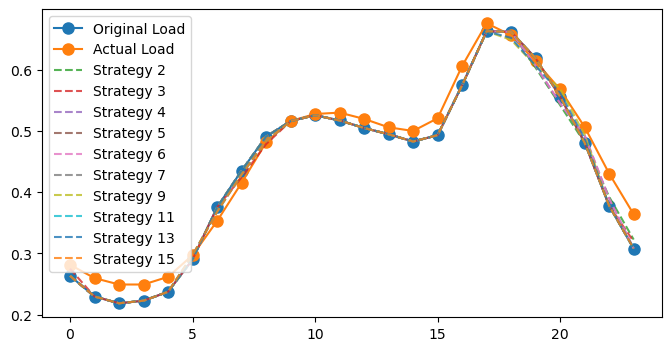

Found 0 relevant failed reflection cases for inquiry 0


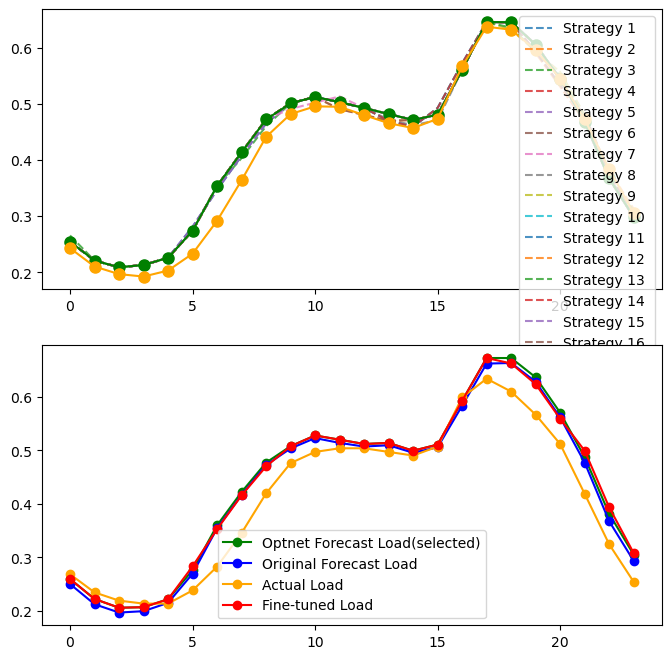

Original cost: 2542.2191690191626, Optnet cost: 2544.5700436720253, Fine-tuned cost: 2539.01058325776
以下样本（inqure_id）未完成LLM微调，使用了原始预测曲线结果: []
以下样本（inqure_id）在验证集上未能找到有效策略，使用了原始预测曲线结果: []
Processing inquiry 2/29
similar days original cost: 2498.911522821417 similar days optnet cost: 2515.1942297720216
Found 3 similar days for inquiry 1
Generating few-shot prompts based on similar days...
策略生成尝试 #1 (当前有效策略: 0/20)
发现有效策略 strategy_4，成本 2496.35, 原始成本 2498.91, (降低 2.56)
策略生成尝试 #2 (当前有效策略: 1/20)
发现有效策略 strategy_5，成本 2495.33, 原始成本 2498.91, (降低 3.58)
策略生成尝试 #3 (当前有效策略: 2/20)
give actual value
发现有效策略 strategy_5，成本 2495.73, 原始成本 2498.91, (降低 3.18)
策略生成尝试 #4 (当前有效策略: 3/20)
give actual value
发现有效策略 strategy_5，成本 2495.73, 原始成本 2498.91, (降低 3.18)
发现有效策略 strategy_8，成本 2496.54, 原始成本 2498.91, (降低 2.37)
策略生成尝试 #5 (当前有效策略: 5/20)
give actual value
发现有效策略 strategy_5，成本 2497.50, 原始成本 2498.91, (降低 1.41)
策略生成尝试 #6 (当前有效策略: 6/20)
give actual value
发现有效策略 strategy_5，成本 2491.32, 原始成本 2498.91, (降低 7.59)
发现有效策略 str

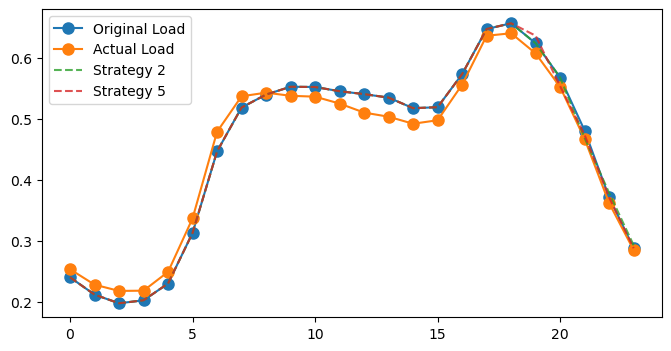

Found 0 relevant failed reflection cases for inquiry 1


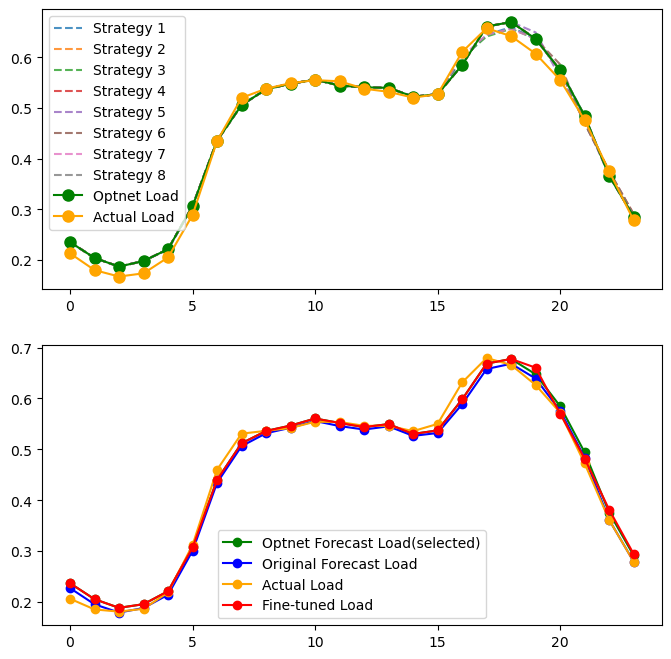

Original cost: 2563.987950395972, Optnet cost: 2544.445129061669, Fine-tuned cost: 2544.8730041659414
策略生成尝试 #1 (当前有效策略: 0/5)
发现有效策略 strategy_6，成本 2548.77, 原始成本 2563.99, (降低 15.21)
策略生成尝试 #2 (当前有效策略: 1/5)
give actual value
发现有效策略 strategy_3，成本 2562.97, 原始成本 2563.99, (降低 1.02)
策略生成尝试 #3 (当前有效策略: 2/5)
give actual value
发现有效策略 strategy_3，成本 2547.88, 原始成本 2563.99, (降低 16.11)
2553.103559707567
2544.507586366847
2541.9417937118506


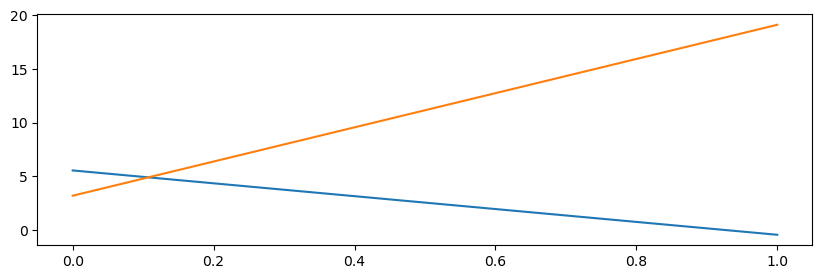

以下样本（inqure_id）未完成LLM微调，使用了原始预测曲线结果: []
以下样本（inqure_id）在验证集上未能找到有效策略，使用了原始预测曲线结果: []
Processing inquiry 3/29
similar days original cost: 2570.8920236602726 similar days optnet cost: 2581.6658456427954
Found 3 similar days for inquiry 2
Generating few-shot prompts based on similar days...
策略生成尝试 #1 (当前有效策略: 0/20)
发现有效策略 strategy_3，成本 2568.01, 原始成本 2570.89, (降低 2.88)
发现有效策略 strategy_5，成本 2569.23, 原始成本 2570.89, (降低 1.67)
发现有效策略 strategy_6，成本 2569.10, 原始成本 2570.89, (降低 1.79)
发现有效策略 strategy_7，成本 2566.35, 原始成本 2570.89, (降低 4.54)
发现有效策略 strategy_8，成本 2563.84, 原始成本 2570.89, (降低 7.05)
发现有效策略 strategy_10，成本 2557.98, 原始成本 2570.89, (降低 12.92)
策略生成尝试 #2 (当前有效策略: 6/20)
发现有效策略 strategy_1，成本 2568.73, 原始成本 2570.89, (降低 2.16)
发现有效策略 strategy_6，成本 2567.03, 原始成本 2570.89, (降低 3.86)
发现有效策略 strategy_7，成本 2568.14, 原始成本 2570.89, (降低 2.75)
发现有效策略 strategy_10，成本 2563.16, 原始成本 2570.89, (降低 7.74)
策略生成尝试 #3 (当前有效策略: 10/20)
give actual value
发现有效策略 strategy_4，成本 2566.29, 原始成本 2570.89, (降低 4.61)
发现有效策略 strategy_5，成本

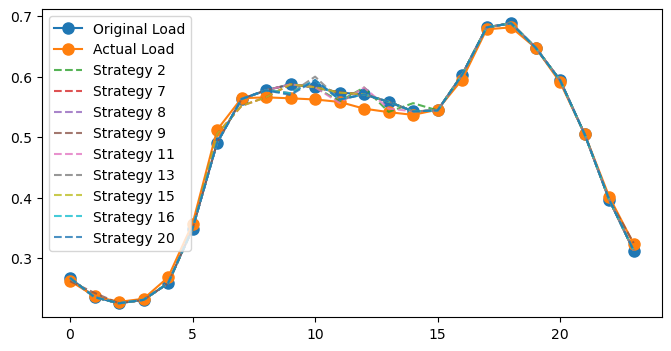

Found 0 relevant failed reflection cases for inquiry 2


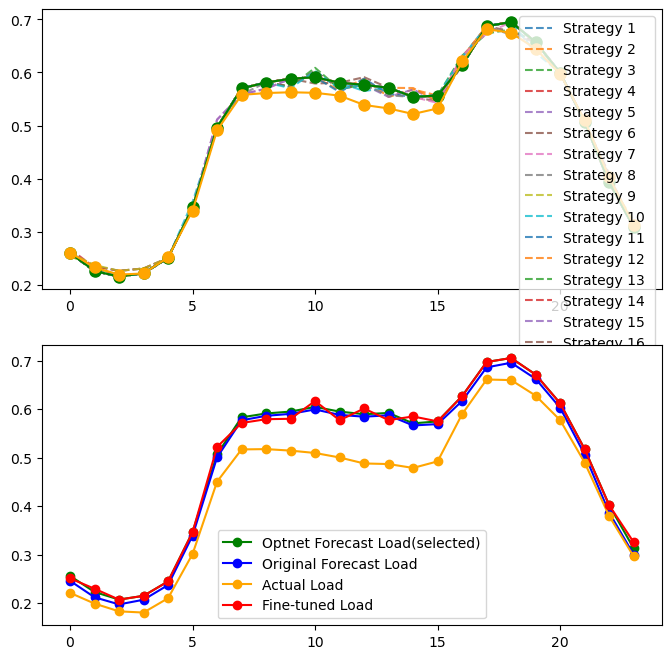

Original cost: 2671.7846971765457, Optnet cost: 2723.330770526856, Fine-tuned cost: 2722.2881812639357
2592.6639388638932
2604.1153144201835
2602.0572562292123


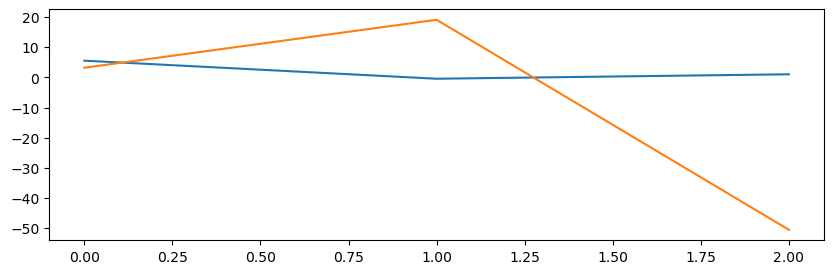

以下样本（inqure_id）未完成LLM微调，使用了原始预测曲线结果: []
以下样本（inqure_id）在验证集上未能找到有效策略，使用了原始预测曲线结果: []
Processing inquiry 4/29
similar days original cost: 2573.2899296729074 similar days optnet cost: 2539.530576103658
Found 3 similar days for inquiry 3
Generating few-shot prompts based on similar days...
策略生成尝试 #1 (当前有效策略: 0/20)
发现有效策略 strategy_6，成本 2559.68, 原始成本 2573.29, (降低 13.61)
发现有效策略 strategy_7，成本 2570.52, 原始成本 2573.29, (降低 2.77)
策略生成尝试 #2 (当前有效策略: 2/20)
发现有效策略 strategy_4，成本 2568.55, 原始成本 2573.29, (降低 4.74)
发现有效策略 strategy_5，成本 2559.68, 原始成本 2573.29, (降低 13.61)
发现有效策略 strategy_7，成本 2567.31, 原始成本 2573.29, (降低 5.98)
发现有效策略 strategy_10，成本 2571.96, 原始成本 2573.29, (降低 1.33)
策略生成尝试 #3 (当前有效策略: 6/20)
give actual value
发现有效策略 strategy_5，成本 2564.56, 原始成本 2573.29, (降低 8.73)
发现有效策略 strategy_6，成本 2563.26, 原始成本 2573.29, (降低 10.03)
发现有效策略 strategy_9，成本 2563.97, 原始成本 2573.29, (降低 9.32)
策略生成尝试 #4 (当前有效策略: 9/20)
give actual value
发现有效策略 strategy_3，成本 2569.22, 原始成本 2573.29, (降低 4.07)
发现有效策略 strategy_4，成本 2564.56, 原始

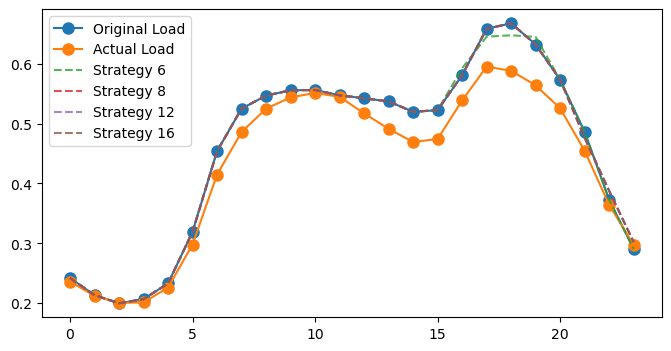

Found 1 relevant failed reflection cases for inquiry 3


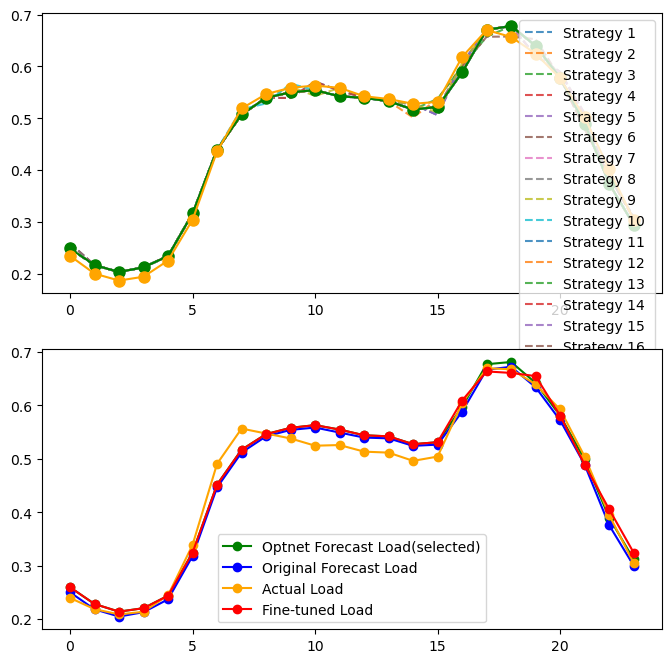

Original cost: 2629.538245284587, Optnet cost: 2590.3918243956864, Fine-tuned cost: 2602.9543249955236
策略生成尝试 #1 (当前有效策略: 0/5)
发现有效策略 strategy_4，成本 2618.97, 原始成本 2629.54, (降低 10.56)
发现有效策略 strategy_5，成本 2598.99, 原始成本 2629.54, (降低 30.55)
发现有效策略 strategy_7，成本 2618.92, 原始成本 2629.54, (降低 10.62)
发现有效策略 strategy_10，成本 2618.76, 原始成本 2629.54, (降低 10.78)
策略生成尝试 #2 (当前有效策略: 4/5)
give actual value
发现有效策略 strategy_4，成本 2616.86, 原始成本 2629.54, (降低 12.68)
2601.8825154690667
2600.6844419140593
2602.28152342079


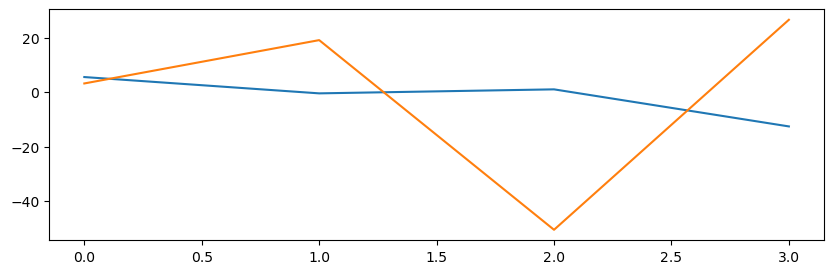

以下样本（inqure_id）未完成LLM微调，使用了原始预测曲线结果: []
以下样本（inqure_id）在验证集上未能找到有效策略，使用了原始预测曲线结果: []
Processing inquiry 5/29
similar days original cost: 2600.1650247490898 similar days optnet cost: 2552.5116554998654
Found 3 similar days for inquiry 4
Generating few-shot prompts based on similar days...
策略生成尝试 #1 (当前有效策略: 0/20)
发现有效策略 strategy_5，成本 2595.54, 原始成本 2600.17, (降低 4.62)
发现有效策略 strategy_6，成本 2595.26, 原始成本 2600.17, (降低 4.91)
发现有效策略 strategy_7，成本 2578.78, 原始成本 2600.17, (降低 21.38)
策略生成尝试 #2 (当前有效策略: 3/20)
发现有效策略 strategy_5，成本 2597.10, 原始成本 2600.17, (降低 3.06)
发现有效策略 strategy_6，成本 2579.05, 原始成本 2600.17, (降低 21.11)
发现有效策略 strategy_7，成本 2596.87, 原始成本 2600.17, (降低 3.30)
策略生成尝试 #3 (当前有效策略: 6/20)
give actual value
发现有效策略 strategy_2，成本 2590.23, 原始成本 2600.17, (降低 9.94)
发现有效策略 strategy_4，成本 2585.88, 原始成本 2600.17, (降低 14.29)
发现有效策略 strategy_6，成本 2599.11, 原始成本 2600.17, (降低 1.05)
发现有效策略 strategy_10，成本 2592.65, 原始成本 2600.17, (降低 7.51)
策略生成尝试 #4 (当前有效策略: 10/20)
give actual value
发现有效策略 strategy_3，成本 2597.45, 

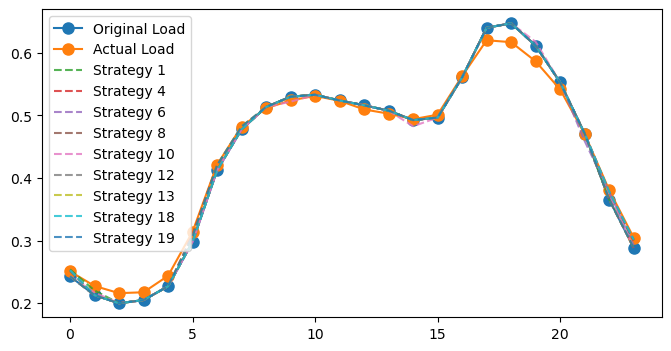

Found 1 relevant failed reflection cases for inquiry 4


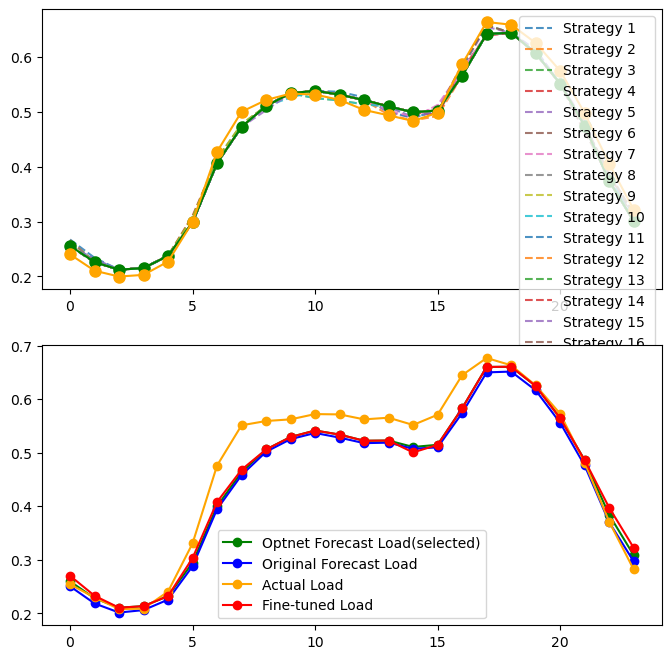

Original cost: 3007.3149539273973, Optnet cost: 2923.678105981946, Fine-tuned cost: 2925.2665074469596
策略生成尝试 #1 (当前有效策略: 0/5)
发现有效策略 strategy_2，成本 2996.91, 原始成本 3007.31, (降低 10.40)
发现有效策略 strategy_4，成本 2989.06, 原始成本 3007.31, (降低 18.26)
发现有效策略 strategy_6，成本 3006.22, 原始成本 3007.31, (降低 1.09)
发现有效策略 strategy_8，成本 2997.64, 原始成本 3007.31, (降低 9.68)
发现有效策略 strategy_9，成本 2994.48, 原始成本 3007.31, (降低 12.83)
2682.969003160733
2665.283174727637
2666.8785202260237


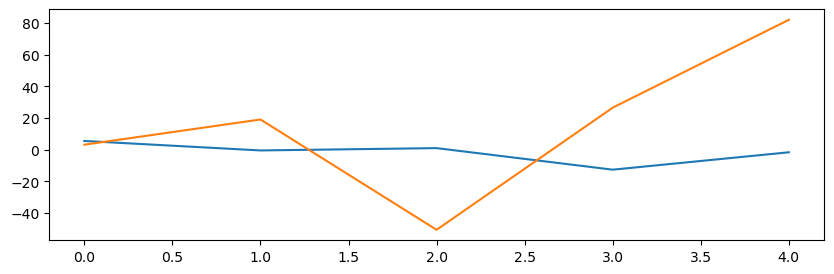

以下样本（inqure_id）未完成LLM微调，使用了原始预测曲线结果: []
以下样本（inqure_id）在验证集上未能找到有效策略，使用了原始预测曲线结果: []
Processing inquiry 6/29
similar days original cost: 2387.10352160342 similar days optnet cost: 2424.3514759806544
Found 3 similar days for inquiry 5
Generating few-shot prompts based on similar days...
策略生成尝试 #1 (当前有效策略: 0/20)
发现有效策略 strategy_1，成本 2373.96, 原始成本 2387.10, (降低 13.14)
发现有效策略 strategy_3，成本 2385.67, 原始成本 2387.10, (降低 1.43)
发现有效策略 strategy_5，成本 2384.34, 原始成本 2387.10, (降低 2.76)
发现有效策略 strategy_6，成本 2385.03, 原始成本 2387.10, (降低 2.07)
发现有效策略 strategy_7，成本 2380.73, 原始成本 2387.10, (降低 6.37)
策略生成尝试 #2 (当前有效策略: 5/20)
发现有效策略 strategy_1，成本 2382.66, 原始成本 2387.10, (降低 4.44)
发现有效策略 strategy_5，成本 2377.11, 原始成本 2387.10, (降低 9.99)
发现有效策略 strategy_6，成本 2385.11, 原始成本 2387.10, (降低 2.00)
发现有效策略 strategy_8，成本 2377.89, 原始成本 2387.10, (降低 9.22)
发现有效策略 strategy_9，成本 2380.74, 原始成本 2387.10, (降低 6.37)
策略生成尝试 #3 (当前有效策略: 10/20)
give actual value
发现有效策略 strategy_1，成本 2380.29, 原始成本 2387.10, (降低 6.82)
发现有效策略 strategy_3，成本 238

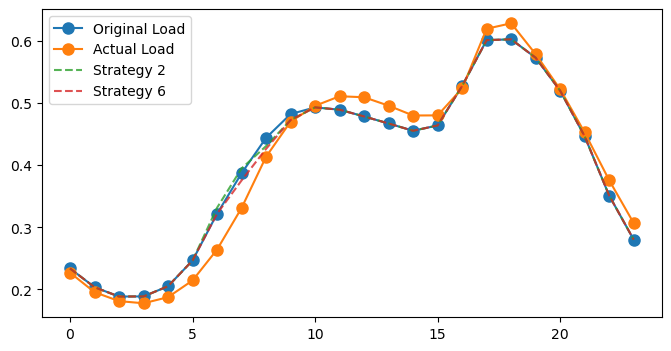

Found 1 relevant failed reflection cases for inquiry 5


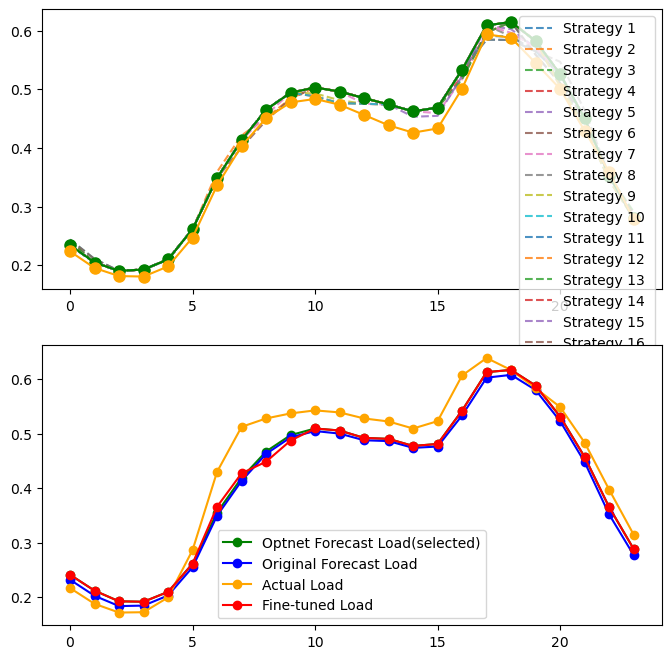

Original cost: 2980.8730139972267, Optnet cost: 2903.0256438441575, Fine-tuned cost: 2909.7487780407187
策略生成尝试 #1 (当前有效策略: 0/5)
发现有效策略 strategy_5，成本 2977.07, 原始成本 2980.87, (降低 3.80)
策略生成尝试 #2 (当前有效策略: 1/5)
give actual value
发现有效策略 strategy_3，成本 2977.83, 原始成本 2980.87, (降低 3.04)
发现有效策略 strategy_4，成本 2979.01, 原始成本 2980.87, (降低 1.87)
发现有效策略 strategy_5，成本 2973.86, 原始成本 2980.87, (降低 7.01)
发现有效策略 strategy_8，成本 2979.48, 原始成本 2980.87, (降低 1.40)
2732.6196716334816
2704.90691958039
2707.356896528473


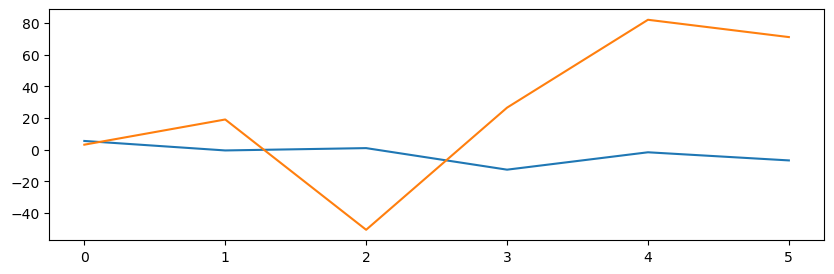

以下样本（inqure_id）未完成LLM微调，使用了原始预测曲线结果: []
以下样本（inqure_id）在验证集上未能找到有效策略，使用了原始预测曲线结果: []
Processing inquiry 7/29
similar days original cost: 2409.8484177398886 similar days optnet cost: 2418.1397237641813
Found 3 similar days for inquiry 6
Generating few-shot prompts based on similar days...
策略生成尝试 #1 (当前有效策略: 0/20)
策略生成尝试 #2 (当前有效策略: 0/20)
发现有效策略 strategy_4，成本 2408.01, 原始成本 2409.85, (降低 1.83)
策略生成尝试 #3 (当前有效策略: 1/20)
give actual value
发现有效策略 strategy_4，成本 2407.77, 原始成本 2409.85, (降低 2.08)
策略生成尝试 #4 (当前有效策略: 2/20)
give actual value
发现有效策略 strategy_4，成本 2407.77, 原始成本 2409.85, (降低 2.08)
策略生成尝试 #5 (当前有效策略: 3/20)
give actual value
发现有效策略 strategy_4，成本 2407.77, 原始成本 2409.85, (降低 2.08)
策略生成尝试 #6 (当前有效策略: 4/20)
give actual value
发现有效策略 strategy_4，成本 2407.77, 原始成本 2409.85, (降低 2.08)
发现有效策略 strategy_7，成本 2408.46, 原始成本 2409.85, (降低 1.39)
发现有效策略 strategy_9，成本 2405.95, 原始成本 2409.85, (降低 3.90)
在验证集上策略 Strategy 1 成功，成本 2514.52, 原始成本 2516.32, (降低 1.81)
在验证集上策略 Strategy 2 成功，成本 2514.30, 原始成本 2516.32, (降低 2

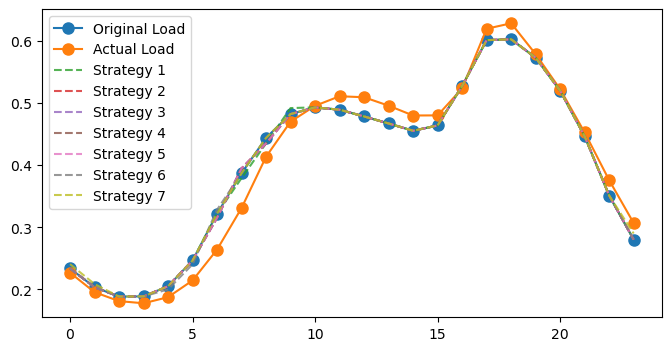

Found 1 relevant failed reflection cases for inquiry 6


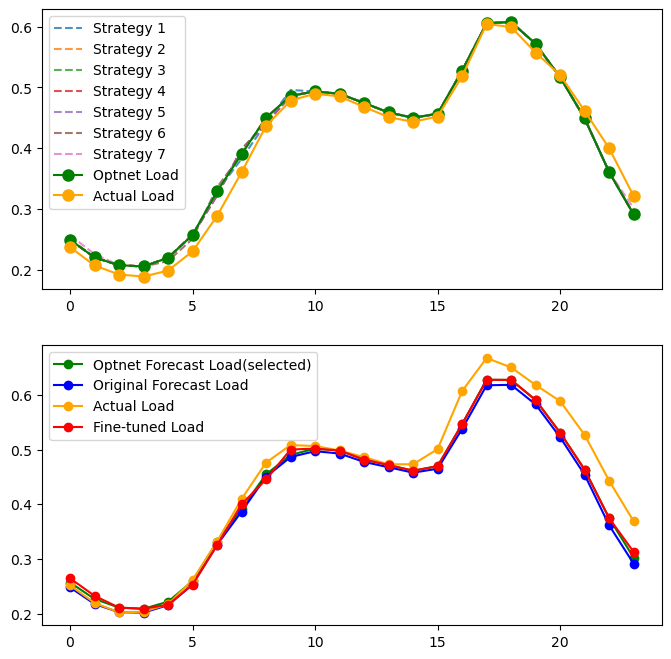

Original cost: 2838.6203544892073, Optnet cost: 2748.293281190515, Fine-tuned cost: 2746.855169990998
2747.762626327157
2711.1049712389795
2712.9995070231193


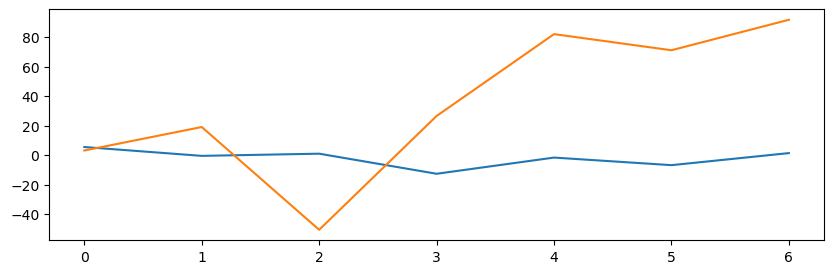

以下样本（inqure_id）未完成LLM微调，使用了原始预测曲线结果: []
以下样本（inqure_id）在验证集上未能找到有效策略，使用了原始预测曲线结果: []
Processing inquiry 8/29
similar days original cost: 2580.3073414390783 similar days optnet cost: 2548.5697874565226
Found 3 similar days for inquiry 7
Generating few-shot prompts based on similar days...
策略生成尝试 #1 (当前有效策略: 0/20)
发现有效策略 strategy_1，成本 2578.72, 原始成本 2580.31, (降低 1.59)
发现有效策略 strategy_3，成本 2578.99, 原始成本 2580.31, (降低 1.32)
发现有效策略 strategy_4，成本 2575.38, 原始成本 2580.31, (降低 4.93)
发现有效策略 strategy_7，成本 2575.61, 原始成本 2580.31, (降低 4.69)
策略生成尝试 #2 (当前有效策略: 4/20)
发现有效策略 strategy_3，成本 2576.89, 原始成本 2580.31, (降低 3.41)
发现有效策略 strategy_7，成本 2574.55, 原始成本 2580.31, (降低 5.76)
策略生成尝试 #3 (当前有效策略: 6/20)
give actual value
发现有效策略 strategy_3，成本 2576.89, 原始成本 2580.31, (降低 3.41)
发现有效策略 strategy_4，成本 2574.55, 原始成本 2580.31, (降低 5.76)
发现有效策略 strategy_10，成本 2576.45, 原始成本 2580.31, (降低 3.86)
策略生成尝试 #4 (当前有效策略: 9/20)
give actual value
发现有效策略 strategy_3，成本 2576.89, 原始成本 2580.31, (降低 3.41)
发现有效策略 strategy_4，成本 2574.55, 原始成本

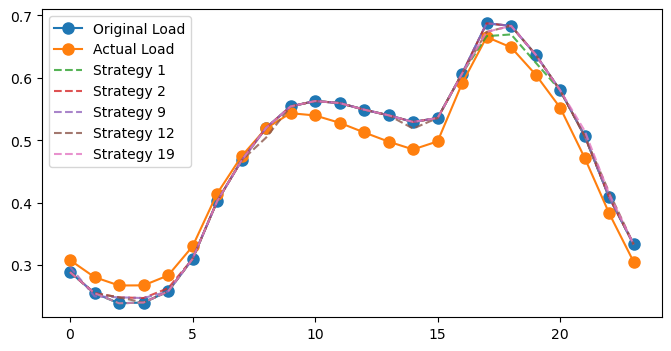

Found 1 relevant failed reflection cases for inquiry 7


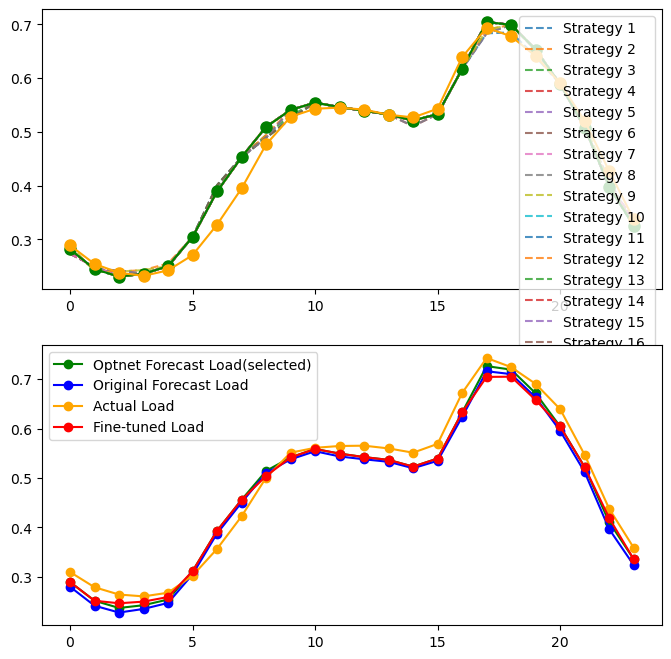

Original cost: 2928.452487846911, Optnet cost: 2823.607498575926, Fine-tuned cost: 2834.5689599004777
策略生成尝试 #1 (当前有效策略: 0/5)
发现有效策略 strategy_3，成本 2911.63, 原始成本 2928.45, (降低 16.83)
发现有效策略 strategy_7，成本 2915.42, 原始成本 2928.45, (降低 13.03)
策略生成尝试 #2 (当前有效策略: 2/5)
give actual value
发现有效策略 strategy_2，成本 2911.63, 原始成本 2928.45, (降低 16.83)
发现有效策略 strategy_3，成本 2924.65, 原始成本 2928.45, (降低 3.80)
发现有效策略 strategy_4，成本 2902.16, 原始成本 2928.45, (降低 26.29)
2770.348859017126
2725.167787156098
2728.1956886327894


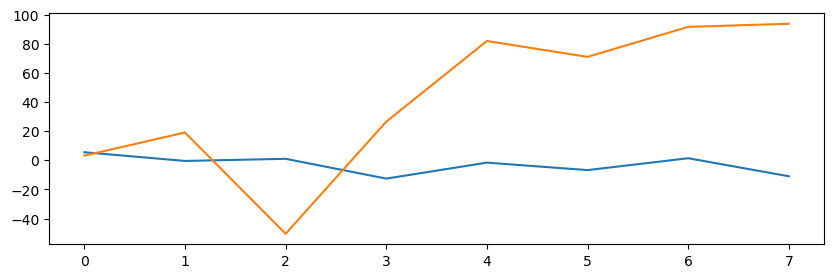

以下样本（inqure_id）未完成LLM微调，使用了原始预测曲线结果: []
以下样本（inqure_id）在验证集上未能找到有效策略，使用了原始预测曲线结果: []
Processing inquiry 9/29
similar days original cost: 2720.589481968145 similar days optnet cost: 2773.461922691524
Found 3 similar days for inquiry 8
Generating few-shot prompts based on similar days...
策略生成尝试 #1 (当前有效策略: 0/20)
发现有效策略 strategy_1，成本 2705.80, 原始成本 2720.59, (降低 14.79)
发现有效策略 strategy_6，成本 2715.88, 原始成本 2720.59, (降低 4.71)
发现有效策略 strategy_7，成本 2718.02, 原始成本 2720.59, (降低 2.57)
发现有效策略 strategy_9，成本 2716.13, 原始成本 2720.59, (降低 4.46)
策略生成尝试 #2 (当前有效策略: 4/20)
发现有效策略 strategy_1，成本 2715.66, 原始成本 2720.59, (降低 4.93)
发现有效策略 strategy_3，成本 2715.77, 原始成本 2720.59, (降低 4.82)
发现有效策略 strategy_4，成本 2719.09, 原始成本 2720.59, (降低 1.50)
发现有效策略 strategy_6，成本 2717.19, 原始成本 2720.59, (降低 3.40)
发现有效策略 strategy_8，成本 2715.10, 原始成本 2720.59, (降低 5.49)
发现有效策略 strategy_10，成本 2719.32, 原始成本 2720.59, (降低 1.27)
策略生成尝试 #3 (当前有效策略: 10/20)
give actual value
发现有效策略 strategy_1，成本 2699.91, 原始成本 2720.59, (降低 20.68)
发现有效策略 strategy_2，成本 2

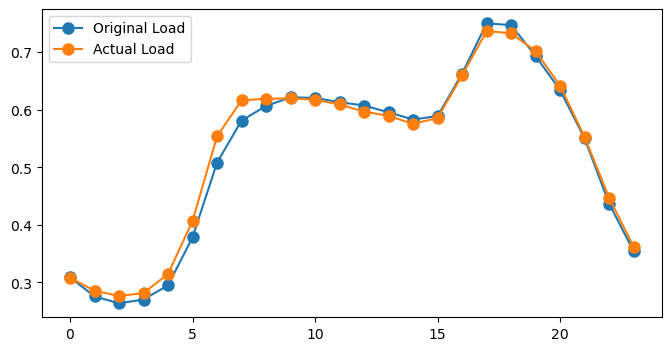

Inquiry 8: No valid strategy found, using original curve as fine-tuned result.
2806.2167073697315
2758.102349215448
2760.7938171947294


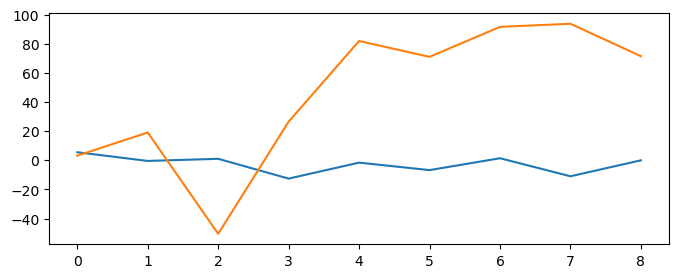

Processing inquiry 10/29
similar days original cost: 2750.0715639483033 similar days optnet cost: 2800.960836375465
Found 3 similar days for inquiry 9
Generating few-shot prompts based on similar days...
策略生成尝试 #1 (当前有效策略: 0/20)
发现有效策略 strategy_1，成本 2731.33, 原始成本 2750.07, (降低 18.75)
发现有效策略 strategy_3，成本 2744.35, 原始成本 2750.07, (降低 5.72)
发现有效策略 strategy_5，成本 2736.21, 原始成本 2750.07, (降低 13.86)
发现有效策略 strategy_9，成本 2738.87, 原始成本 2750.07, (降低 11.20)
发现有效策略 strategy_10，成本 2745.91, 原始成本 2750.07, (降低 4.17)
策略生成尝试 #2 (当前有效策略: 5/20)
发现有效策略 strategy_1，成本 2731.33, 原始成本 2750.07, (降低 18.75)
发现有效策略 strategy_2，成本 2741.53, 原始成本 2750.07, (降低 8.54)
发现有效策略 strategy_3，成本 2738.06, 原始成本 2750.07, (降低 12.02)
发现有效策略 strategy_5，成本 2736.21, 原始成本 2750.07, (降低 13.86)
发现有效策略 strategy_6，成本 2739.00, 原始成本 2750.07, (降低 11.07)
发现有效策略 strategy_9，成本 2739.30, 原始成本 2750.07, (降低 10.78)
发现有效策略 strategy_10，成本 2744.52, 原始成本 2750.07, (降低 5.56)
策略生成尝试 #3 (当前有效策略: 12/20)
give actual value
发现有效策略 strategy_1，成本 2725.71, 原始成本 2750.07, 

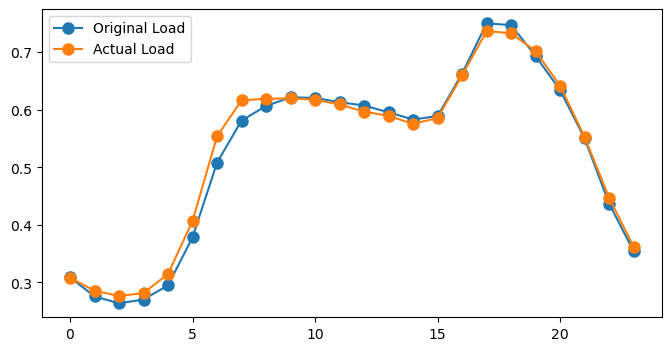

Inquiry 9: No valid strategy found, using original curve as fine-tuned result.
2820.699204707521
2770.0159412458897
2772.438262427243


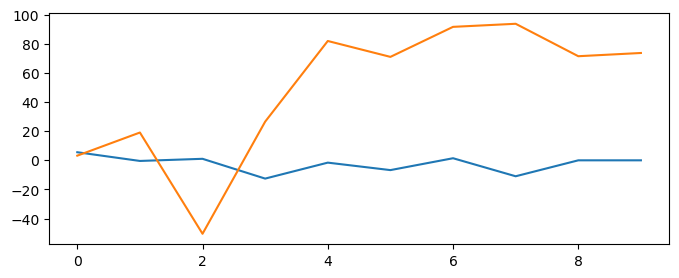

Processing inquiry 11/29
similar days original cost: 2720.589481968145 similar days optnet cost: 2773.461922691524
Found 3 similar days for inquiry 10
Generating few-shot prompts based on similar days...
策略生成尝试 #1 (当前有效策略: 0/20)
发现有效策略 strategy_1，成本 2704.72, 原始成本 2720.59, (降低 15.87)
发现有效策略 strategy_4，成本 2713.10, 原始成本 2720.59, (降低 7.48)
发现有效策略 strategy_5，成本 2719.33, 原始成本 2720.59, (降低 1.26)
发现有效策略 strategy_7，成本 2710.92, 原始成本 2720.59, (降低 9.66)
发现有效策略 strategy_9，成本 2714.58, 原始成本 2720.59, (降低 6.01)
策略生成尝试 #2 (当前有效策略: 5/20)
发现有效策略 strategy_1，成本 2704.72, 原始成本 2720.59, (降低 15.87)
发现有效策略 strategy_3，成本 2715.78, 原始成本 2720.59, (降低 4.81)
发现有效策略 strategy_4，成本 2713.01, 原始成本 2720.59, (降低 7.58)
发现有效策略 strategy_5，成本 2715.26, 原始成本 2720.59, (降低 5.32)
发现有效策略 strategy_6，成本 2717.76, 原始成本 2720.59, (降低 2.83)
发现有效策略 strategy_7，成本 2710.92, 原始成本 2720.59, (降低 9.66)
发现有效策略 strategy_8，成本 2715.06, 原始成本 2720.59, (降低 5.53)
发现有效策略 strategy_9，成本 2714.58, 原始成本 2720.59, (降低 6.01)
发现有效策略 strategy_10，成本 2717.57, 原始成本 2720.5

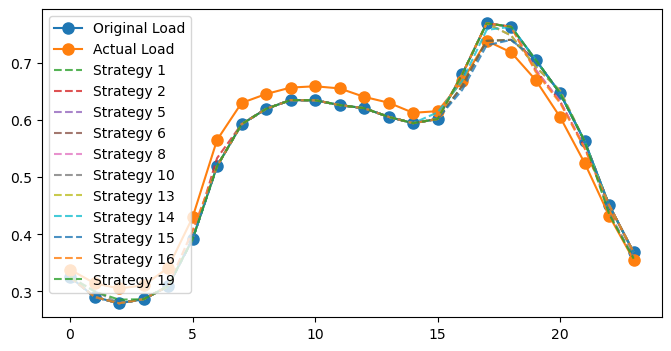

Found 1 relevant failed reflection cases for inquiry 10


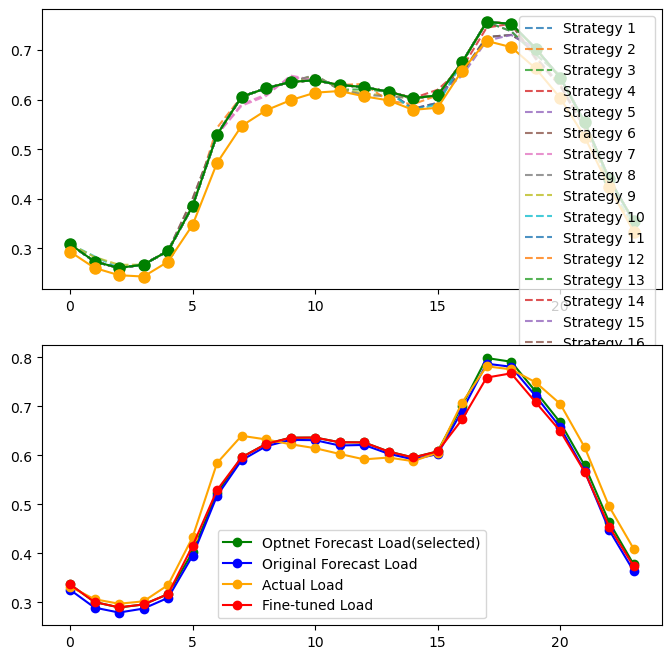

Original cost: 3033.3861763555406, Optnet cost: 2947.9905699509977, Fine-tuned cost: 3014.7323060223607
策略生成尝试 #1 (当前有效策略: 0/5)
发现有效策略 strategy_3，成本 3006.93, 原始成本 3033.39, (降低 26.45)
发现有效策略 strategy_4，成本 3030.11, 原始成本 3033.39, (降低 3.27)
发现有效策略 strategy_7，成本 3027.84, 原始成本 3033.39, (降低 5.54)
发现有效策略 strategy_9，成本 3007.74, 原始成本 3033.39, (降低 25.65)
策略生成尝试 #2 (当前有效策略: 4/5)
give actual value
发现有效策略 strategy_3，成本 3006.93, 原始成本 3033.39, (降低 26.45)
2840.0343839482503
2786.195452946354
2794.4649936631627


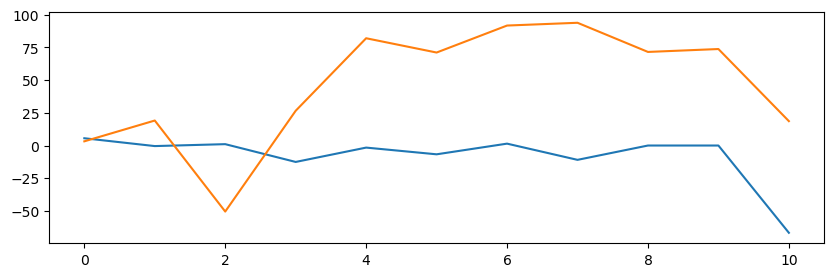

以下样本（inqure_id）未完成LLM微调，使用了原始预测曲线结果: [8, 9]
以下样本（inqure_id）在验证集上未能找到有效策略，使用了原始预测曲线结果: []
Processing inquiry 12/29
similar days original cost: 2815.76591800187 similar days optnet cost: 2823.640954253117
Found 3 similar days for inquiry 11
Generating few-shot prompts based on similar days...
策略生成尝试 #1 (当前有效策略: 0/20)
发现有效策略 strategy_1，成本 2800.35, 原始成本 2815.77, (降低 15.42)
发现有效策略 strategy_3，成本 2794.21, 原始成本 2815.77, (降低 21.55)
发现有效策略 strategy_4，成本 2809.95, 原始成本 2815.77, (降低 5.81)
发现有效策略 strategy_5，成本 2814.74, 原始成本 2815.77, (降低 1.02)
发现有效策略 strategy_6，成本 2809.66, 原始成本 2815.77, (降低 6.11)
发现有效策略 strategy_9，成本 2805.42, 原始成本 2815.77, (降低 10.35)
策略生成尝试 #2 (当前有效策略: 6/20)
发现有效策略 strategy_1，成本 2800.35, 原始成本 2815.77, (降低 15.42)
发现有效策略 strategy_2，成本 2814.74, 原始成本 2815.77, (降低 1.02)
发现有效策略 strategy_3，成本 2794.21, 原始成本 2815.77, (降低 21.55)
发现有效策略 strategy_4，成本 2809.95, 原始成本 2815.77, (降低 5.81)
发现有效策略 strategy_5，成本 2809.66, 原始成本 2815.77, (降低 6.11)
发现有效策略 strategy_7，成本 2806.55, 原始成本 2815.77, (降低 9.22)
发现有效策

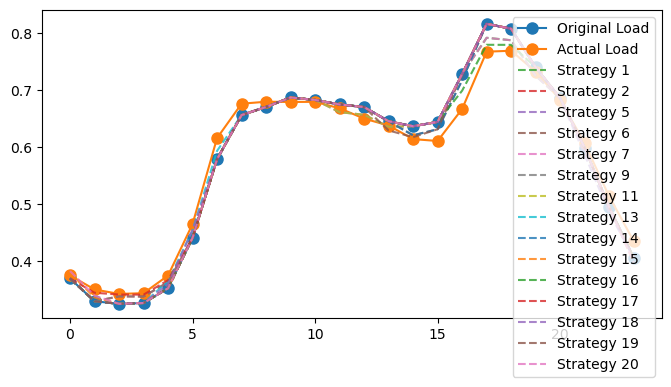

Found 1 relevant failed reflection cases for inquiry 11


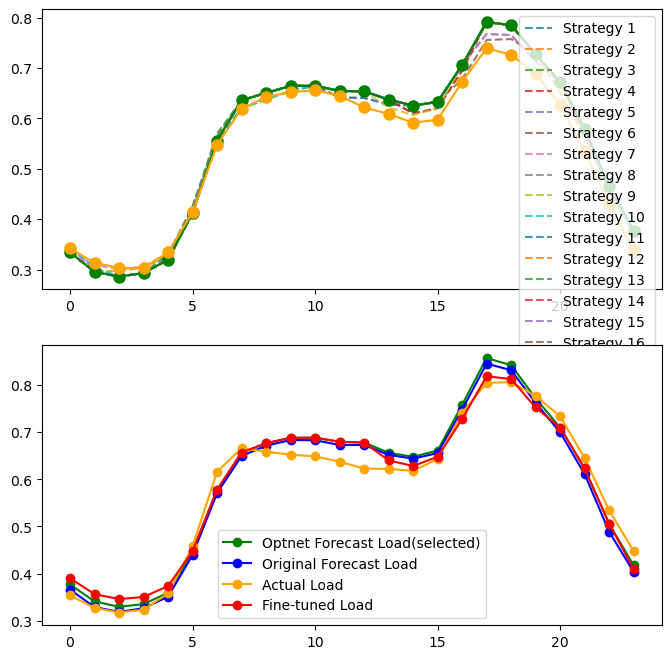

Original cost: 3001.612160353601, Optnet cost: 2967.6584888739585, Fine-tuned cost: 2980.1933910509288
策略生成尝试 #1 (当前有效策略: 0/5)
发现有效策略 strategy_1，成本 2995.35, 原始成本 3001.61, (降低 6.26)
发现有效策略 strategy_4，成本 2984.75, 原始成本 3001.61, (降低 16.86)
发现有效策略 strategy_5，成本 2987.40, 原始成本 3001.61, (降低 14.21)
发现有效策略 strategy_8，成本 2977.91, 原始成本 3001.61, (降低 23.71)
策略生成尝试 #2 (当前有效策略: 4/5)
give actual value
发现有效策略 strategy_3，成本 2986.53, 原始成本 3001.61, (降低 15.08)
2853.499198648696
2801.3173726069876
2809.942360112143


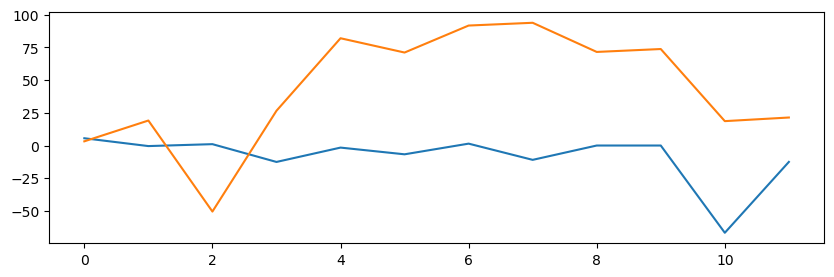

以下样本（inqure_id）未完成LLM微调，使用了原始预测曲线结果: [8, 9]
以下样本（inqure_id）在验证集上未能找到有效策略，使用了原始预测曲线结果: []
Processing inquiry 13/29
similar days original cost: 2815.76591800187 similar days optnet cost: 2823.640954253117
Found 3 similar days for inquiry 12
Generating few-shot prompts based on similar days...
策略生成尝试 #1 (当前有效策略: 0/20)
发现有效策略 strategy_1，成本 2801.39, 原始成本 2815.77, (降低 14.37)
发现有效策略 strategy_3，成本 2794.48, 原始成本 2815.77, (降低 21.28)
发现有效策略 strategy_6，成本 2812.56, 原始成本 2815.77, (降低 3.21)
发现有效策略 strategy_8，成本 2811.68, 原始成本 2815.77, (降低 4.08)
策略生成尝试 #2 (当前有效策略: 4/20)
发现有效策略 strategy_1，成本 2801.39, 原始成本 2815.77, (降低 14.37)
发现有效策略 strategy_3，成本 2794.48, 原始成本 2815.77, (降低 21.28)
发现有效策略 strategy_6，成本 2812.56, 原始成本 2815.77, (降低 3.21)
发现有效策略 strategy_7，成本 2806.24, 原始成本 2815.77, (降低 9.52)
发现有效策略 strategy_8，成本 2811.68, 原始成本 2815.77, (降低 4.08)
策略生成尝试 #3 (当前有效策略: 9/20)
give actual value
发现有效策略 strategy_1，成本 2795.26, 原始成本 2815.77, (降低 20.51)
发现有效策略 strategy_2，成本 2794.33, 原始成本 2815.77, (降低 21.43)
发现有效策略 strategy

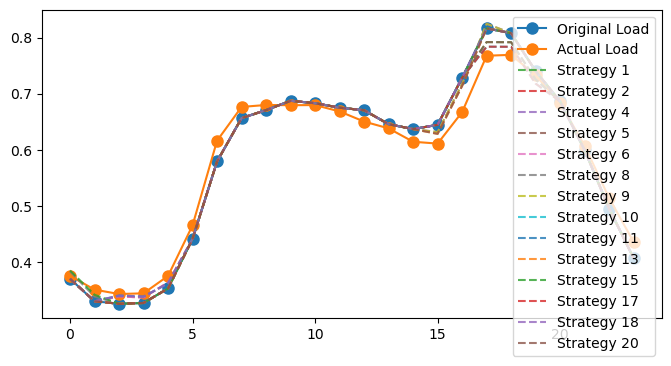

Found 1 relevant failed reflection cases for inquiry 12


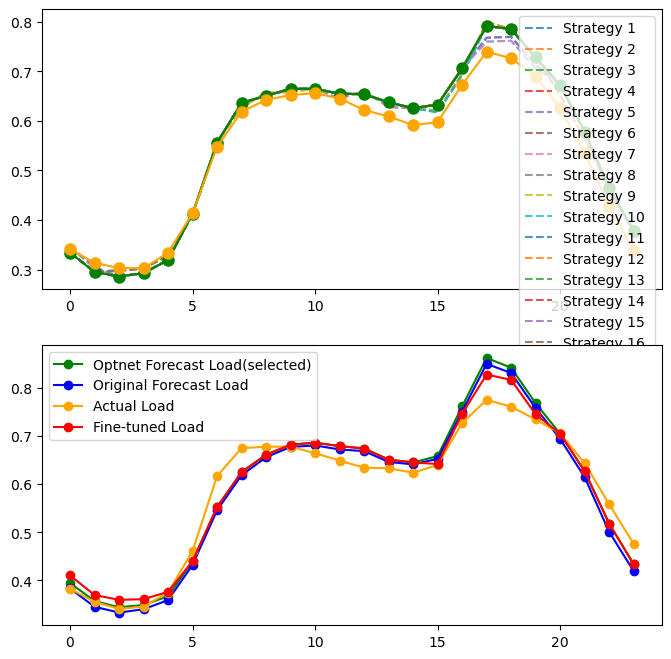

Original cost: 3091.9744719560144, Optnet cost: 3038.6978486726885, Fine-tuned cost: 3017.841142627984
2871.8434504415663
2819.5774092274264
2825.934574151823


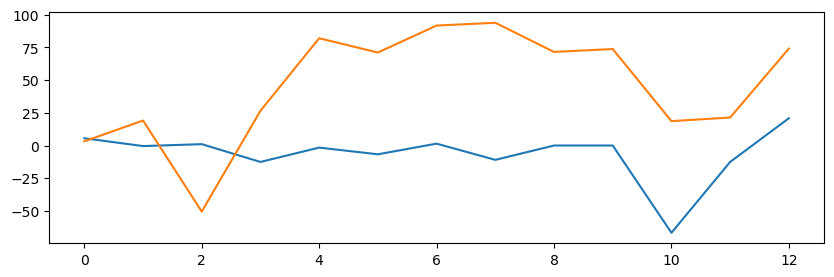

以下样本（inqure_id）未完成LLM微调，使用了原始预测曲线结果: [8, 9]
以下样本（inqure_id）在验证集上未能找到有效策略，使用了原始预测曲线结果: []
Processing inquiry 14/29
similar days original cost: 2746.4552264762524 similar days optnet cost: 2755.3602366184796
Found 3 similar days for inquiry 13
Generating few-shot prompts based on similar days...
策略生成尝试 #1 (当前有效策略: 0/20)
发现有效策略 strategy_1，成本 2729.39, 原始成本 2746.46, (降低 17.06)
发现有效策略 strategy_2，成本 2736.26, 原始成本 2746.46, (降低 10.20)
发现有效策略 strategy_3，成本 2730.56, 原始成本 2746.46, (降低 15.89)
发现有效策略 strategy_4，成本 2744.60, 原始成本 2746.46, (降低 1.86)
发现有效策略 strategy_6，成本 2741.71, 原始成本 2746.46, (降低 4.75)
发现有效策略 strategy_7，成本 2738.07, 原始成本 2746.46, (降低 8.39)
发现有效策略 strategy_8，成本 2732.39, 原始成本 2746.46, (降低 14.07)
发现有效策略 strategy_10，成本 2726.02, 原始成本 2746.46, (降低 20.44)
策略生成尝试 #2 (当前有效策略: 8/20)
发现有效策略 strategy_1，成本 2728.00, 原始成本 2746.46, (降低 18.45)
发现有效策略 strategy_2，成本 2737.23, 原始成本 2746.46, (降低 9.23)
发现有效策略 strategy_3，成本 2730.56, 原始成本 2746.46, (降低 15.89)
发现有效策略 strategy_4，成本 2744.60, 原始成本 2746.46, (降低 1.86)

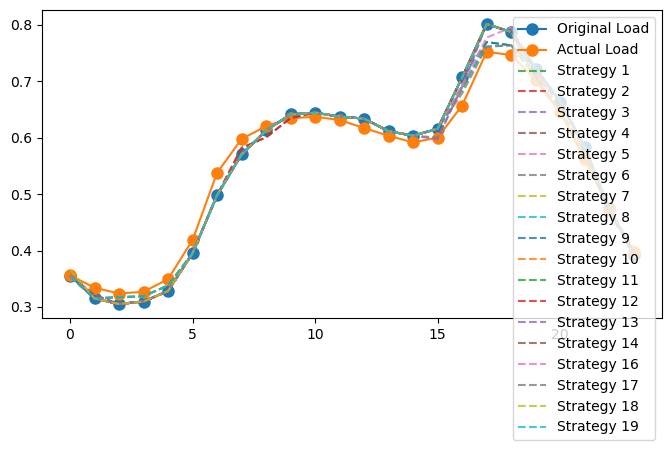

Found 1 relevant failed reflection cases for inquiry 13


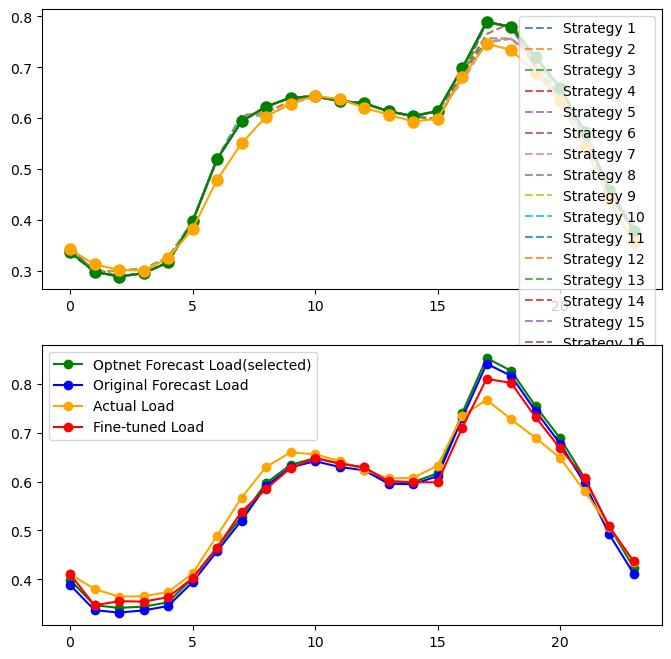

Original cost: 3060.7738320928215, Optnet cost: 2978.065191516817, Fine-tuned cost: 2942.201289458179
2885.3384777023703
2830.89796510524
2834.2393395308486


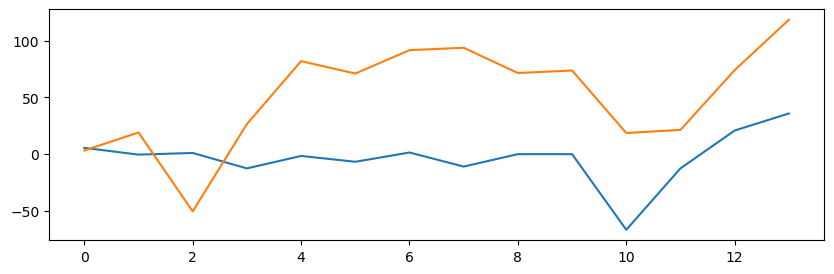

以下样本（inqure_id）未完成LLM微调，使用了原始预测曲线结果: [8, 9]
以下样本（inqure_id）在验证集上未能找到有效策略，使用了原始预测曲线结果: []
Processing inquiry 15/29
similar days original cost: 2699.0273535826404 similar days optnet cost: 2738.321677025219
Found 3 similar days for inquiry 14
Generating few-shot prompts based on similar days...
策略生成尝试 #1 (当前有效策略: 0/20)
发现有效策略 strategy_3，成本 2688.93, 原始成本 2699.03, (降低 10.09)
发现有效策略 strategy_9，成本 2695.79, 原始成本 2699.03, (降低 3.24)
策略生成尝试 #2 (当前有效策略: 2/20)
发现有效策略 strategy_2，成本 2695.92, 原始成本 2699.03, (降低 3.11)
发现有效策略 strategy_3，成本 2688.13, 原始成本 2699.03, (降低 10.89)
发现有效策略 strategy_4，成本 2681.07, 原始成本 2699.03, (降低 17.95)
发现有效策略 strategy_6，成本 2696.93, 原始成本 2699.03, (降低 2.10)
发现有效策略 strategy_7，成本 2696.60, 原始成本 2699.03, (降低 2.43)
发现有效策略 strategy_8，成本 2692.68, 原始成本 2699.03, (降低 6.35)
发现有效策略 strategy_10，成本 2693.55, 原始成本 2699.03, (降低 5.48)
策略生成尝试 #3 (当前有效策略: 9/20)
give actual value
发现有效策略 strategy_1，成本 2675.56, 原始成本 2699.03, (降低 23.46)
发现有效策略 strategy_3，成本 2683.51, 原始成本 2699.03, (降低 15.52)
发现有效策略 strate

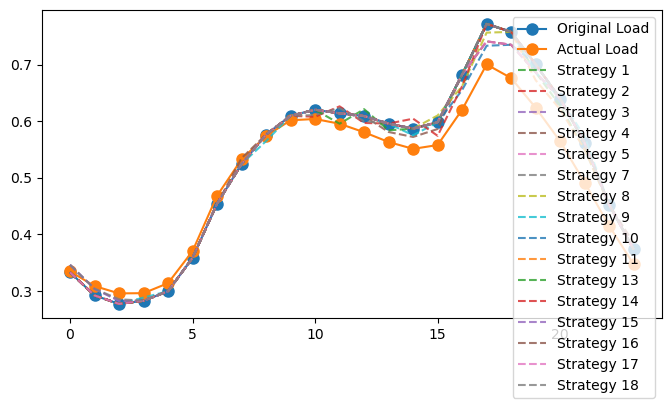

Found 1 relevant failed reflection cases for inquiry 14


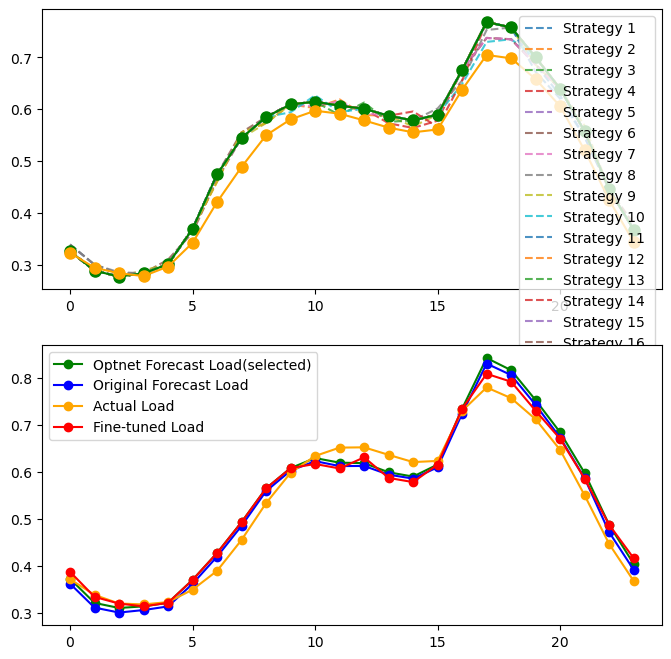

Original cost: 2886.3691417390705, Optnet cost: 2858.1269902995828, Fine-tuned cost: 2846.81918213889
2885.4071886381503
2832.7132334515295
2835.077995704718


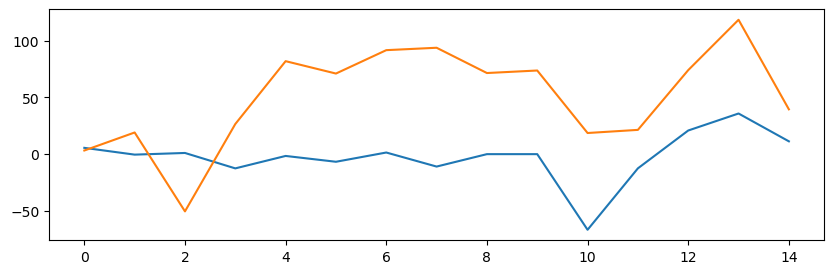

以下样本（inqure_id）未完成LLM微调，使用了原始预测曲线结果: [8, 9]
以下样本（inqure_id）在验证集上未能找到有效策略，使用了原始预测曲线结果: []
Processing inquiry 16/29
similar days original cost: 2815.76591800187 similar days optnet cost: 2823.640954253117
Found 3 similar days for inquiry 15
Generating few-shot prompts based on similar days...
策略生成尝试 #1 (当前有效策略: 0/20)
发现有效策略 strategy_1，成本 2799.30, 原始成本 2815.77, (降低 16.46)
发现有效策略 strategy_3，成本 2792.55, 原始成本 2815.77, (降低 23.21)
发现有效策略 strategy_5，成本 2803.22, 原始成本 2815.77, (降低 12.54)
发现有效策略 strategy_8，成本 2807.13, 原始成本 2815.77, (降低 8.63)
发现有效策略 strategy_9，成本 2810.26, 原始成本 2815.77, (降低 5.51)
发现有效策略 strategy_10，成本 2814.35, 原始成本 2815.77, (降低 1.42)
策略生成尝试 #2 (当前有效策略: 6/20)
发现有效策略 strategy_2，成本 2812.36, 原始成本 2815.77, (降低 3.40)
发现有效策略 strategy_3，成本 2790.85, 原始成本 2815.77, (降低 24.92)
发现有效策略 strategy_4，成本 2810.61, 原始成本 2815.77, (降低 5.16)
发现有效策略 strategy_5，成本 2809.29, 原始成本 2815.77, (降低 6.48)
发现有效策略 strategy_8，成本 2810.45, 原始成本 2815.77, (降低 5.31)
发现有效策略 strategy_9，成本 2812.81, 原始成本 2815.77, (降低 2.96)
策略生成尝

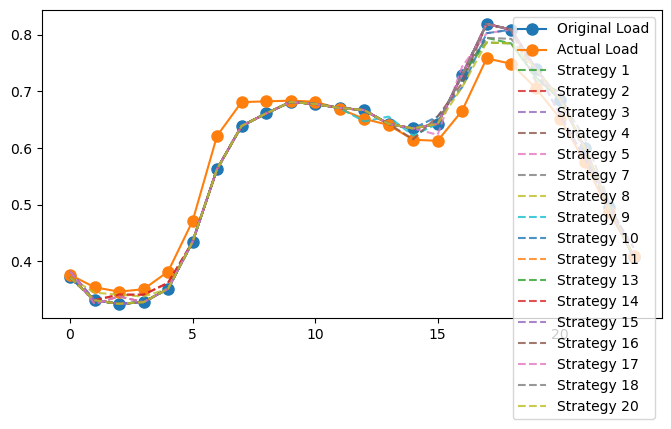

Found 0 relevant failed reflection cases for inquiry 15


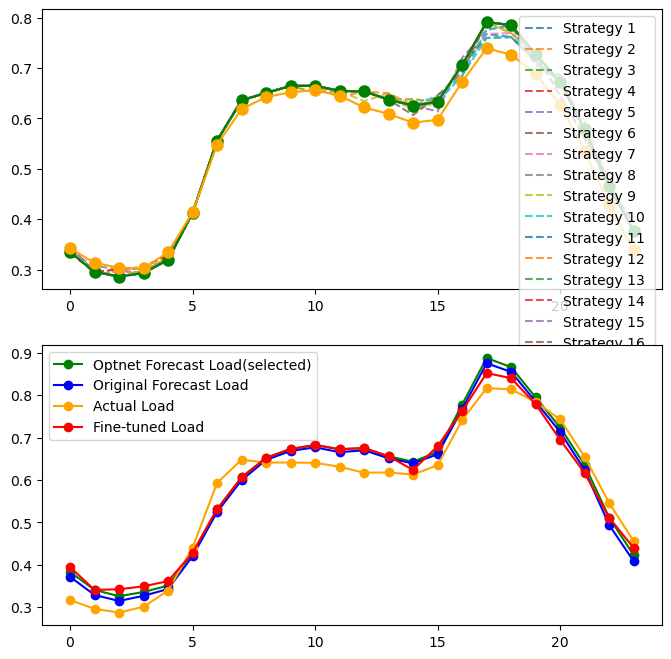

Original cost: 3059.438257263124, Optnet cost: 3042.3013023434282, Fine-tuned cost: 3056.6288912971195
策略生成尝试 #1 (当前有效策略: 0/5)
发现有效策略 strategy_1，成本 3058.43, 原始成本 3059.44, (降低 1.01)
发现有效策略 strategy_6，成本 3054.29, 原始成本 3059.44, (降低 5.15)
发现有效策略 strategy_7，成本 3054.02, 原始成本 3059.44, (降低 5.42)
发现有效策略 strategy_8，成本 3053.69, 原始成本 3059.44, (降低 5.75)
策略生成尝试 #2 (当前有效策略: 4/5)
give actual value
发现有效策略 strategy_4，成本 3054.02, 原始成本 3059.44, (降低 5.42)
2896.2841304272115
2845.812487757273
2848.924926679243


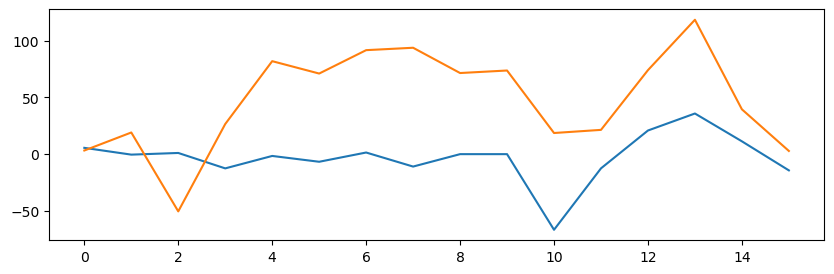

以下样本（inqure_id）未完成LLM微调，使用了原始预测曲线结果: [8, 9]
以下样本（inqure_id）在验证集上未能找到有效策略，使用了原始预测曲线结果: []
Processing inquiry 17/29
similar days original cost: 2925.269474831035 similar days optnet cost: 2947.817038541128
Found 3 similar days for inquiry 16
Generating few-shot prompts based on similar days...
策略生成尝试 #1 (当前有效策略: 0/20)
发现有效策略 strategy_1，成本 2910.90, 原始成本 2925.27, (降低 14.37)
发现有效策略 strategy_6，成本 2919.45, 原始成本 2925.27, (降低 5.82)
发现有效策略 strategy_9，成本 2920.58, 原始成本 2925.27, (降低 4.69)
发现有效策略 strategy_10，成本 2915.18, 原始成本 2925.27, (降低 10.09)
策略生成尝试 #2 (当前有效策略: 4/20)
发现有效策略 strategy_1，成本 2910.90, 原始成本 2925.27, (降低 14.37)
发现有效策略 strategy_2，成本 2922.68, 原始成本 2925.27, (降低 2.59)
发现有效策略 strategy_3，成本 2923.59, 原始成本 2925.27, (降低 1.68)
发现有效策略 strategy_4，成本 2920.56, 原始成本 2925.27, (降低 4.71)
发现有效策略 strategy_5，成本 2919.45, 原始成本 2925.27, (降低 5.82)
发现有效策略 strategy_6，成本 2912.10, 原始成本 2925.27, (降低 13.17)
发现有效策略 strategy_7，成本 2920.74, 原始成本 2925.27, (降低 4.53)
发现有效策略 strategy_8，成本 2923.80, 原始成本 2925.27, (降低 1.47)
发现有效

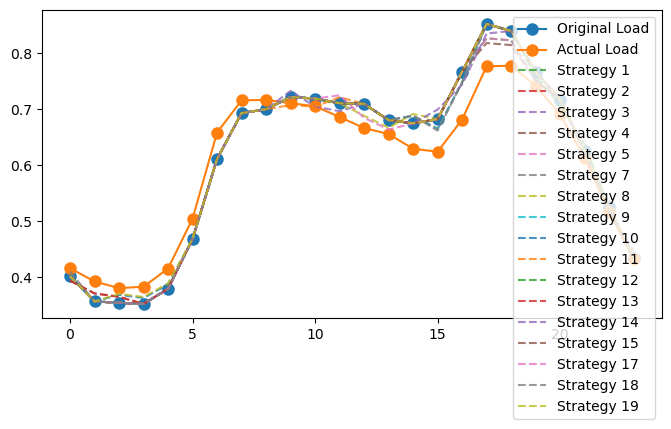

Found 0 relevant failed reflection cases for inquiry 16


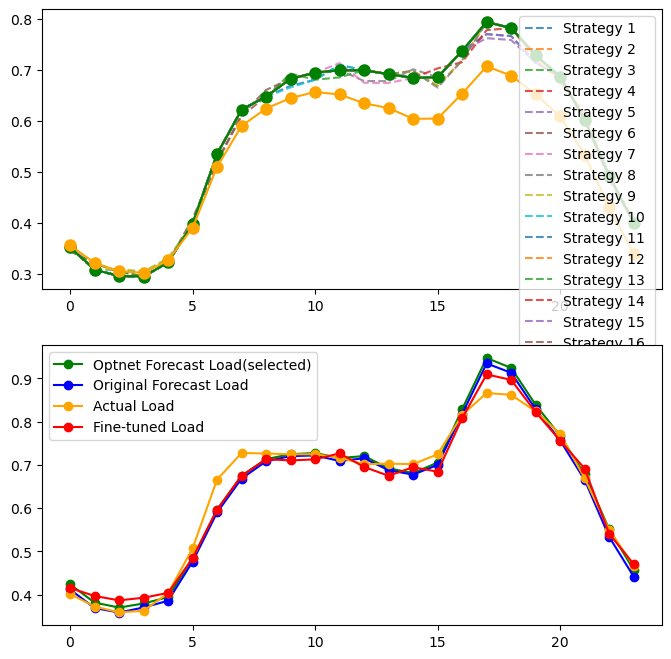

Original cost: 3154.8055843421816, Optnet cost: 3103.8846212369203, Fine-tuned cost: 3137.352105356494
策略生成尝试 #1 (当前有效策略: 0/5)
发现有效策略 strategy_5，成本 3149.76, 原始成本 3154.81, (降低 5.05)
发现有效策略 strategy_6，成本 3143.91, 原始成本 3154.81, (降低 10.89)
发现有效策略 strategy_8，成本 3151.57, 原始成本 3154.81, (降低 3.23)
策略生成尝试 #2 (当前有效策略: 3/5)
give actual value
发现有效策略 strategy_1，成本 3137.57, 原始成本 3154.81, (降低 17.23)
发现有效策略 strategy_5，成本 3152.15, 原始成本 3154.81, (降低 2.66)
2911.491274775151
2860.9932014913697
2865.8912313073165


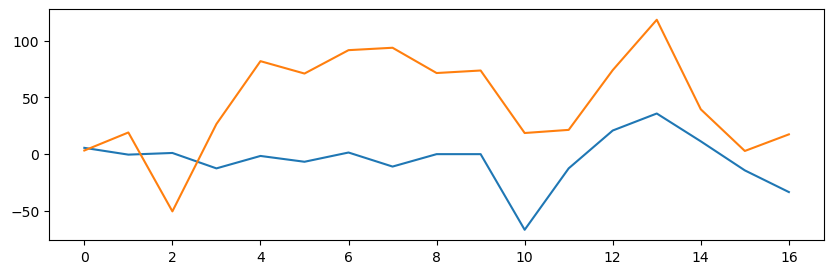

以下样本（inqure_id）未完成LLM微调，使用了原始预测曲线结果: [8, 9]
以下样本（inqure_id）在验证集上未能找到有效策略，使用了原始预测曲线结果: []
Processing inquiry 18/29
similar days original cost: 2925.269474831035 similar days optnet cost: 2947.817038541128
Found 3 similar days for inquiry 17
Generating few-shot prompts based on similar days...
策略生成尝试 #1 (当前有效策略: 0/20)
发现有效策略 strategy_1，成本 2910.90, 原始成本 2925.27, (降低 14.37)
发现有效策略 strategy_3，成本 2912.86, 原始成本 2925.27, (降低 12.40)
发现有效策略 strategy_4，成本 2918.93, 原始成本 2925.27, (降低 6.34)
发现有效策略 strategy_7，成本 2922.73, 原始成本 2925.27, (降低 2.54)
发现有效策略 strategy_10，成本 2918.71, 原始成本 2925.27, (降低 6.56)
策略生成尝试 #2 (当前有效策略: 5/20)
发现有效策略 strategy_1，成本 2904.78, 原始成本 2925.27, (降低 20.49)
发现有效策略 strategy_2，成本 2912.86, 原始成本 2925.27, (降低 12.40)
发现有效策略 strategy_3，成本 2919.32, 原始成本 2925.27, (降低 5.95)
发现有效策略 strategy_5，成本 2921.93, 原始成本 2925.27, (降低 3.34)
发现有效策略 strategy_8，成本 2921.58, 原始成本 2925.27, (降低 3.69)
发现有效策略 strategy_10，成本 2916.65, 原始成本 2925.27, (降低 8.62)
策略生成尝试 #3 (当前有效策略: 11/20)
give actual value
发现有效策略 strate

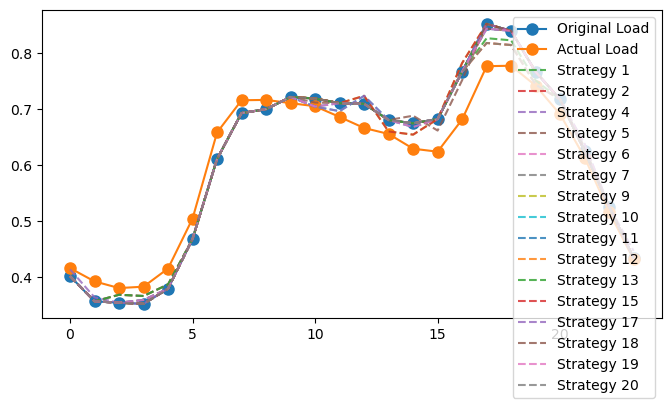

Found 0 relevant failed reflection cases for inquiry 17


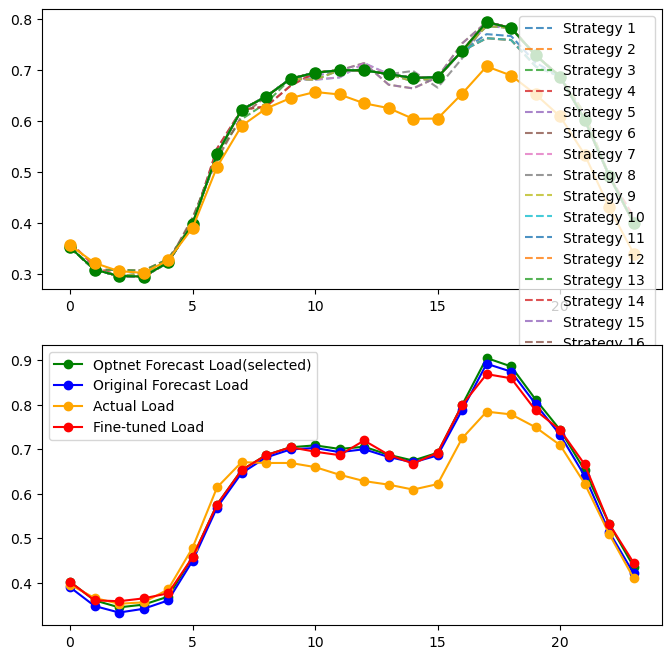

Original cost: 3067.174809405029, Optnet cost: 3058.0413363064526, Fine-tuned cost: 3024.2791525373937
2920.1403600323665
2871.940320092208
2874.690560264543


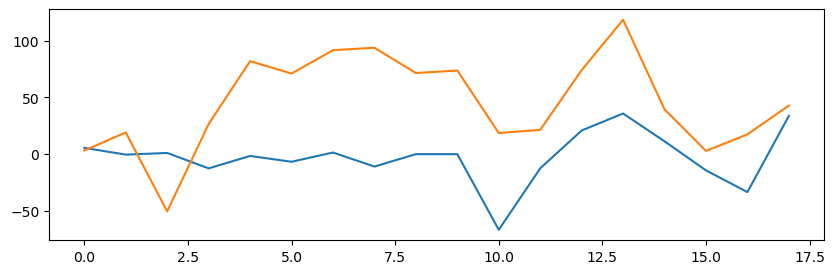

以下样本（inqure_id）未完成LLM微调，使用了原始预测曲线结果: [8, 9]
以下样本（inqure_id）在验证集上未能找到有效策略，使用了原始预测曲线结果: []
Processing inquiry 19/29
similar days original cost: 2746.4552264762524 similar days optnet cost: 2755.3602366184796
Found 3 similar days for inquiry 18
Generating few-shot prompts based on similar days...
策略生成尝试 #1 (当前有效策略: 0/20)
发现有效策略 strategy_1，成本 2732.18, 原始成本 2746.46, (降低 14.28)
发现有效策略 strategy_3，成本 2730.56, 原始成本 2746.46, (降低 15.89)
发现有效策略 strategy_5，成本 2741.31, 原始成本 2746.46, (降低 5.15)
发现有效策略 strategy_6，成本 2740.94, 原始成本 2746.46, (降低 5.52)
发现有效策略 strategy_8，成本 2741.93, 原始成本 2746.46, (降低 4.53)
策略生成尝试 #2 (当前有效策略: 5/20)
发现有效策略 strategy_1，成本 2736.63, 原始成本 2746.46, (降低 9.82)
发现有效策略 strategy_4，成本 2744.95, 原始成本 2746.46, (降低 1.51)
发现有效策略 strategy_6，成本 2729.39, 原始成本 2746.46, (降低 17.06)
发现有效策略 strategy_10，成本 2739.75, 原始成本 2746.46, (降低 6.71)
策略生成尝试 #3 (当前有效策略: 9/20)
give actual value
发现有效策略 strategy_1，成本 2726.09, 原始成本 2746.46, (降低 20.37)
发现有效策略 strategy_2，成本 2731.34, 原始成本 2746.46, (降低 15.11)
发现有效策略 strat

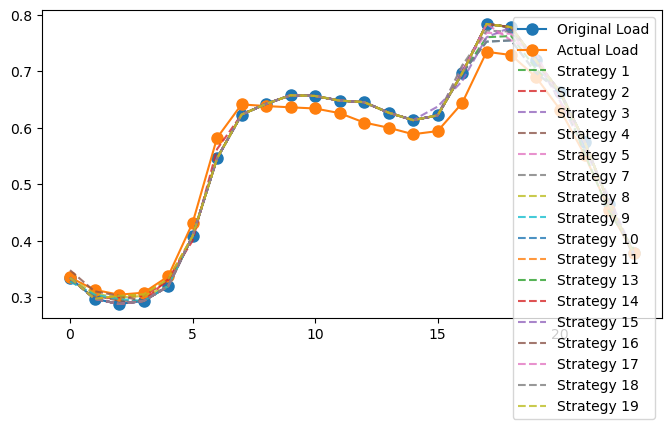

Found 0 relevant failed reflection cases for inquiry 18


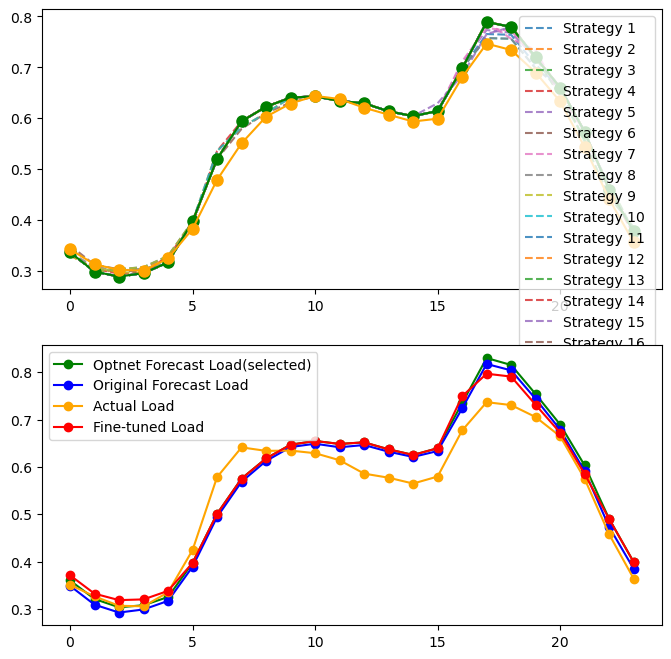

Original cost: 2976.491169150829, Optnet cost: 2968.5492071110607, Fine-tuned cost: 2939.80077690489
2923.106192091233
2877.024998356358
2878.1174137719295


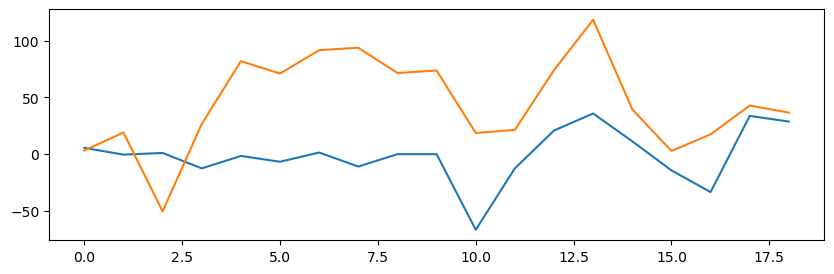

以下样本（inqure_id）未完成LLM微调，使用了原始预测曲线结果: [8, 9]
以下样本（inqure_id）在验证集上未能找到有效策略，使用了原始预测曲线结果: []
Processing inquiry 20/29
similar days original cost: 2684.6170184083385 similar days optnet cost: 2733.791225679875
Found 3 similar days for inquiry 19
Generating few-shot prompts based on similar days...
策略生成尝试 #1 (当前有效策略: 0/20)
发现有效策略 strategy_1，成本 2671.09, 原始成本 2684.62, (降低 13.53)
发现有效策略 strategy_6，成本 2681.42, 原始成本 2684.62, (降低 3.19)
发现有效策略 strategy_10，成本 2679.27, 原始成本 2684.62, (降低 5.34)
策略生成尝试 #2 (当前有效策略: 3/20)
发现有效策略 strategy_1，成本 2665.50, 原始成本 2684.62, (降低 19.12)
发现有效策略 strategy_3，成本 2681.71, 原始成本 2684.62, (降低 2.90)
发现有效策略 strategy_5，成本 2677.40, 原始成本 2684.62, (降低 7.22)
发现有效策略 strategy_6，成本 2681.28, 原始成本 2684.62, (降低 3.34)
发现有效策略 strategy_8，成本 2670.45, 原始成本 2684.62, (降低 14.17)
发现有效策略 strategy_9，成本 2678.87, 原始成本 2684.62, (降低 5.74)
策略生成尝试 #3 (当前有效策略: 9/20)
give actual value
发现有效策略 strategy_1，成本 2661.76, 原始成本 2684.62, (降低 22.86)
发现有效策略 strategy_2，成本 2680.20, 原始成本 2684.62, (降低 4.41)
发现有效策略 strateg

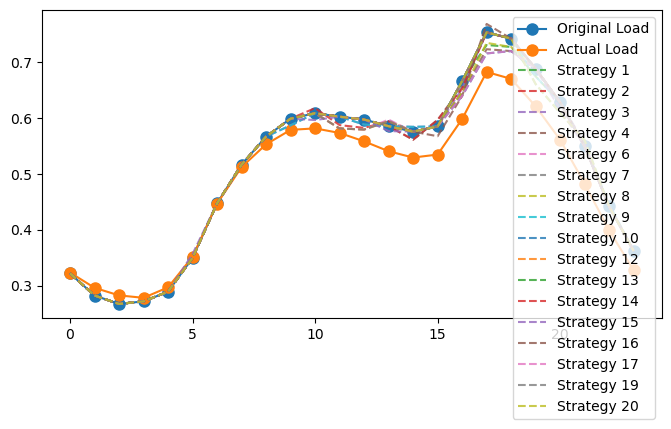

Found 0 relevant failed reflection cases for inquiry 19


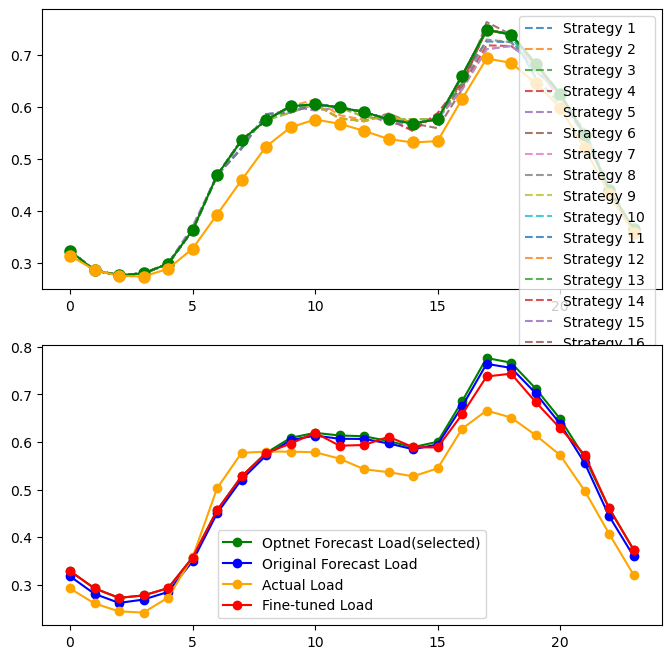

Original cost: 2826.9965489726364, Optnet cost: 2857.0903414242566, Fine-tuned cost: 2807.475179491007
2918.300709935303
2876.028265509753
2874.5853020578834


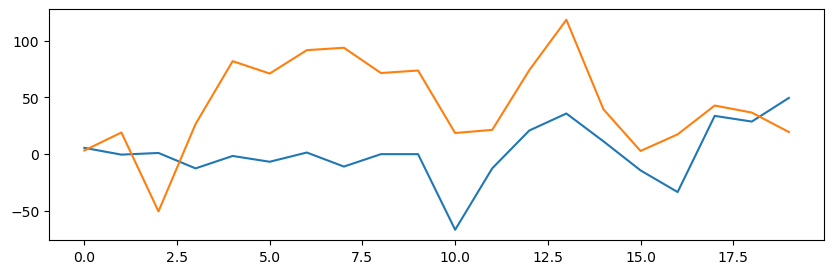

以下样本（inqure_id）未完成LLM微调，使用了原始预测曲线结果: [8, 9]
以下样本（inqure_id）在验证集上未能找到有效策略，使用了原始预测曲线结果: []
Processing inquiry 21/29
similar days original cost: 2572.142115977407 similar days optnet cost: 2551.2794013604325
Found 3 similar days for inquiry 20
Generating few-shot prompts based on similar days...
策略生成尝试 #1 (当前有效策略: 0/20)
发现有效策略 strategy_8，成本 2560.46, 原始成本 2572.14, (降低 11.68)
策略生成尝试 #2 (当前有效策略: 1/20)
发现有效策略 strategy_3，成本 2568.76, 原始成本 2572.14, (降低 3.38)
发现有效策略 strategy_5，成本 2570.13, 原始成本 2572.14, (降低 2.01)
发现有效策略 strategy_6，成本 2564.52, 原始成本 2572.14, (降低 7.62)
发现有效策略 strategy_10，成本 2569.57, 原始成本 2572.14, (降低 2.57)
策略生成尝试 #3 (当前有效策略: 5/20)
give actual value
发现有效策略 strategy_3，成本 2568.88, 原始成本 2572.14, (降低 3.26)
发现有效策略 strategy_4，成本 2567.96, 原始成本 2572.14, (降低 4.18)
发现有效策略 strategy_5，成本 2564.21, 原始成本 2572.14, (降低 7.93)
发现有效策略 strategy_7，成本 2564.74, 原始成本 2572.14, (降低 7.40)
策略生成尝试 #4 (当前有效策略: 9/20)
give actual value
发现有效策略 strategy_3，成本 2568.88, 原始成本 2572.14, (降低 3.26)
发现有效策略 strategy_4，成本 2567.96

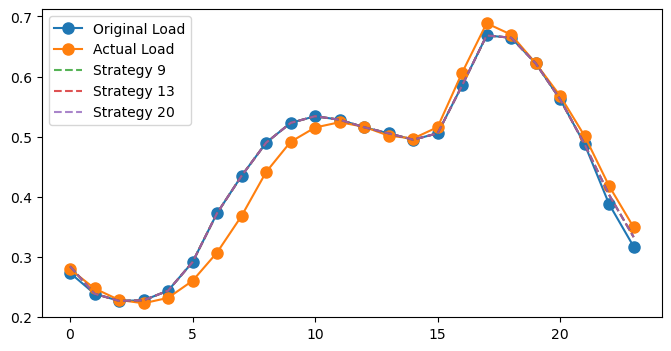

Found 0 relevant failed reflection cases for inquiry 20


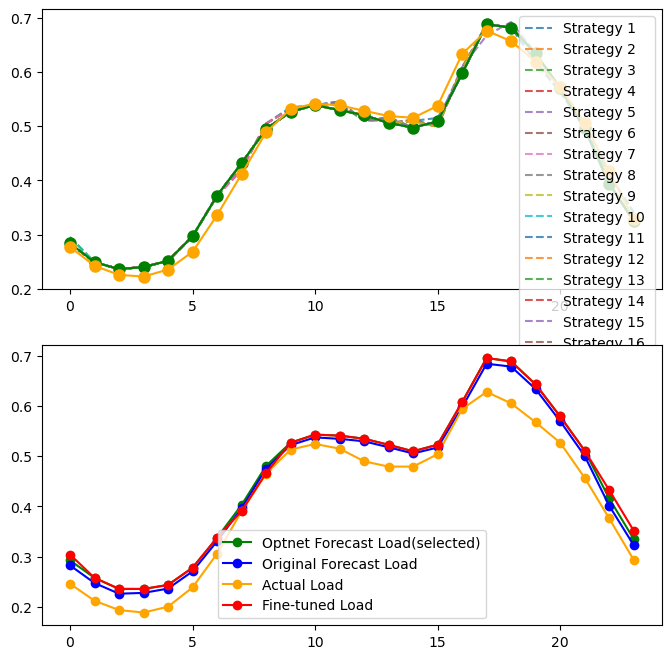

Original cost: 2519.914723799348, Optnet cost: 2571.306141859889, Fine-tuned cost: 2576.1486015015907
策略生成尝试 #1 (当前有效策略: 0/5)
发现有效策略 strategy_1，成本 2506.57, 原始成本 2519.91, (降低 13.34)
发现有效策略 strategy_5，成本 2511.90, 原始成本 2519.91, (降低 8.02)
策略生成尝试 #2 (当前有效策略: 2/5)
give actual value
发现有效策略 strategy_1，成本 2503.85, 原始成本 2519.91, (降低 16.06)
发现有效策略 strategy_5，成本 2509.95, 原始成本 2519.91, (降低 9.96)
发现有效策略 strategy_8，成本 2513.33, 原始成本 2519.91, (降低 6.59)
2899.3299486907335
2861.517688193093
2860.3740306028217


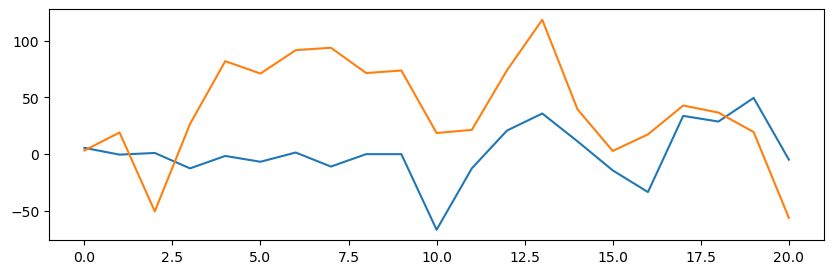

以下样本（inqure_id）未完成LLM微调，使用了原始预测曲线结果: [8, 9]
以下样本（inqure_id）在验证集上未能找到有效策略，使用了原始预测曲线结果: []
Processing inquiry 22/29
similar days original cost: 2572.690603984793 similar days optnet cost: 2544.688111611983
Found 3 similar days for inquiry 21
Generating few-shot prompts based on similar days...
策略生成尝试 #1 (当前有效策略: 0/20)
发现有效策略 strategy_1，成本 2558.93, 原始成本 2572.69, (降低 13.76)
发现有效策略 strategy_3，成本 2569.31, 原始成本 2572.69, (降低 3.38)
发现有效策略 strategy_6，成本 2568.02, 原始成本 2572.69, (降低 4.67)
发现有效策略 strategy_7，成本 2567.20, 原始成本 2572.69, (降低 5.49)
策略生成尝试 #2 (当前有效策略: 4/20)
发现有效策略 strategy_3，成本 2569.81, 原始成本 2572.69, (降低 2.88)
发现有效策略 strategy_7，成本 2567.60, 原始成本 2572.69, (降低 5.09)
发现有效策略 strategy_9，成本 2564.90, 原始成本 2572.69, (降低 7.79)
发现有效策略 strategy_10，成本 2553.57, 原始成本 2572.69, (降低 19.12)
策略生成尝试 #3 (当前有效策略: 8/20)
give actual value
发现有效策略 strategy_1，成本 2554.87, 原始成本 2572.69, (降低 17.82)
发现有效策略 strategy_2，成本 2569.11, 原始成本 2572.69, (降低 3.58)
发现有效策略 strategy_3，成本 2570.14, 原始成本 2572.69, (降低 2.55)
发现有效策略 strategy_

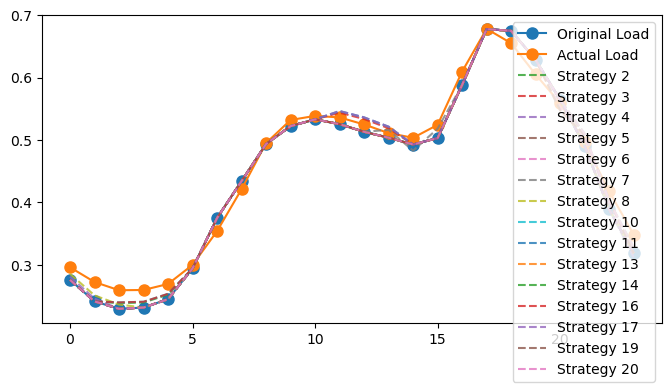

Found 1 relevant failed reflection cases for inquiry 21


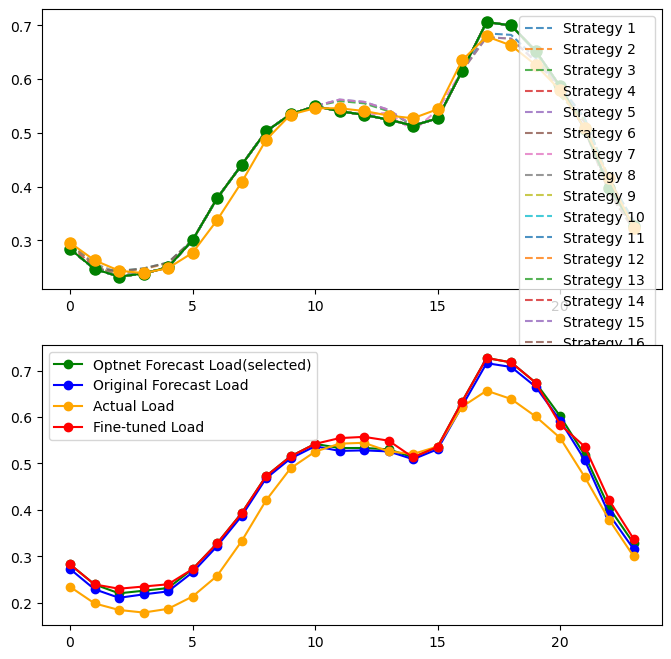

Original cost: 2559.0792721230982, Optnet cost: 2589.115245248795, Fine-tuned cost: 2599.94575122675
策略生成尝试 #1 (当前有效策略: 0/5)
发现有效策略 strategy_1，成本 2546.06, 原始成本 2559.08, (降低 13.02)
发现有效策略 strategy_5，成本 2549.73, 原始成本 2559.08, (降低 9.34)
发现有效策略 strategy_9，成本 2557.46, 原始成本 2559.08, (降低 1.62)
策略生成尝试 #2 (当前有效策略: 3/5)
give actual value
发现有效策略 strategy_1，成本 2557.56, 原始成本 2559.08, (降低 1.52)
发现有效策略 strategy_2，成本 2555.95, 原始成本 2559.08, (降低 3.13)
2883.8640088467505
2849.135758968352
2848.536381540273


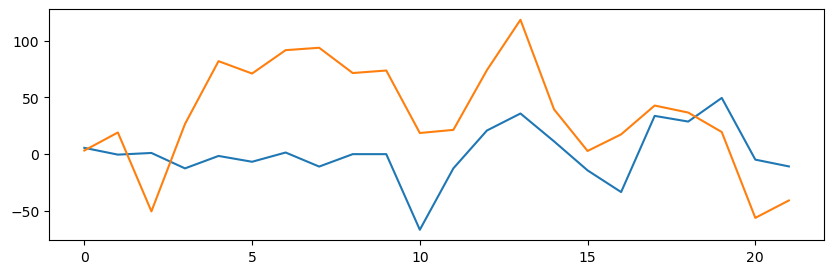

以下样本（inqure_id）未完成LLM微调，使用了原始预测曲线结果: [8, 9]
以下样本（inqure_id）在验证集上未能找到有效策略，使用了原始预测曲线结果: []
Processing inquiry 23/29
similar days original cost: 2660.5250274672408 similar days optnet cost: 2709.5146791682737
Found 3 similar days for inquiry 22
Generating few-shot prompts based on similar days...
策略生成尝试 #1 (当前有效策略: 0/20)
发现有效策略 strategy_1，成本 2641.83, 原始成本 2660.53, (降低 18.69)
发现有效策略 strategy_4，成本 2657.54, 原始成本 2660.53, (降低 2.99)
发现有效策略 strategy_8，成本 2656.87, 原始成本 2660.53, (降低 3.66)
策略生成尝试 #2 (当前有效策略: 3/20)
发现有效策略 strategy_1，成本 2636.23, 原始成本 2660.53, (降低 24.29)
发现有效策略 strategy_3，成本 2654.53, 原始成本 2660.53, (降低 6.00)
发现有效策略 strategy_4，成本 2654.41, 原始成本 2660.53, (降低 6.12)
发现有效策略 strategy_7，成本 2658.32, 原始成本 2660.53, (降低 2.21)
策略生成尝试 #3 (当前有效策略: 7/20)
give actual value
发现有效策略 strategy_1，成本 2636.23, 原始成本 2660.53, (降低 24.29)
发现有效策略 strategy_3，成本 2654.53, 原始成本 2660.53, (降低 6.00)
发现有效策略 strategy_4，成本 2654.41, 原始成本 2660.53, (降低 6.12)
发现有效策略 strategy_5，成本 2654.38, 原始成本 2660.53, (降低 6.14)
发现有效策略 strategy

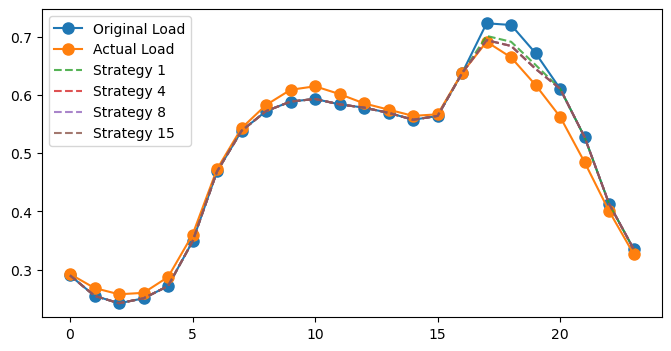

Found 1 relevant failed reflection cases for inquiry 22


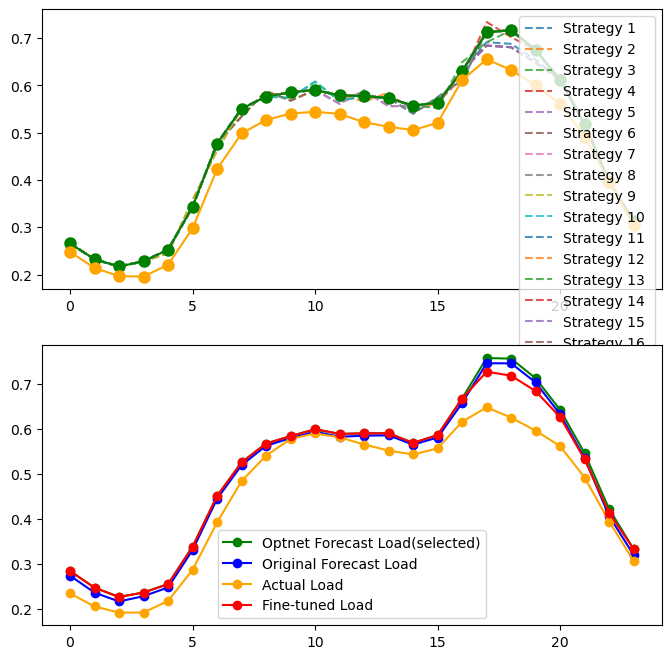

Original cost: 2667.2827522518037, Optnet cost: 2719.652410036385, Fine-tuned cost: 2683.7547294700385
2874.4474324730572
2843.506048145223
2841.3719618850455


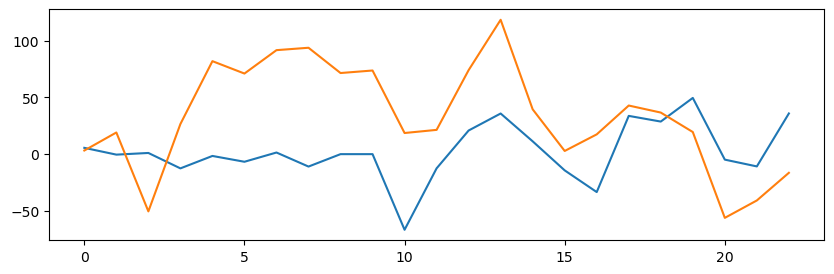

以下样本（inqure_id）未完成LLM微调，使用了原始预测曲线结果: [8, 9]
以下样本（inqure_id）在验证集上未能找到有效策略，使用了原始预测曲线结果: []
Processing inquiry 24/29
similar days original cost: 2669.0128782145975 similar days optnet cost: 2713.8444004385274
Found 3 similar days for inquiry 23
Generating few-shot prompts based on similar days...
策略生成尝试 #1 (当前有效策略: 0/20)
发现有效策略 strategy_1，成本 2650.28, 原始成本 2669.01, (降低 18.74)
发现有效策略 strategy_3，成本 2666.25, 原始成本 2669.01, (降低 2.76)
发现有效策略 strategy_5，成本 2665.25, 原始成本 2669.01, (降低 3.76)
发现有效策略 strategy_8，成本 2664.39, 原始成本 2669.01, (降低 4.62)
发现有效策略 strategy_9，成本 2652.16, 原始成本 2669.01, (降低 16.85)
发现有效策略 strategy_10，成本 2665.71, 原始成本 2669.01, (降低 3.30)
策略生成尝试 #2 (当前有效策略: 6/20)
发现有效策略 strategy_1，成本 2650.28, 原始成本 2669.01, (降低 18.74)
发现有效策略 strategy_3，成本 2666.25, 原始成本 2669.01, (降低 2.76)
发现有效策略 strategy_5，成本 2665.25, 原始成本 2669.01, (降低 3.76)
发现有效策略 strategy_6，成本 2665.99, 原始成本 2669.01, (降低 3.02)
发现有效策略 strategy_8，成本 2664.39, 原始成本 2669.01, (降低 4.62)
发现有效策略 strategy_9，成本 2652.16, 原始成本 2669.01, (降低 16.85)
发现

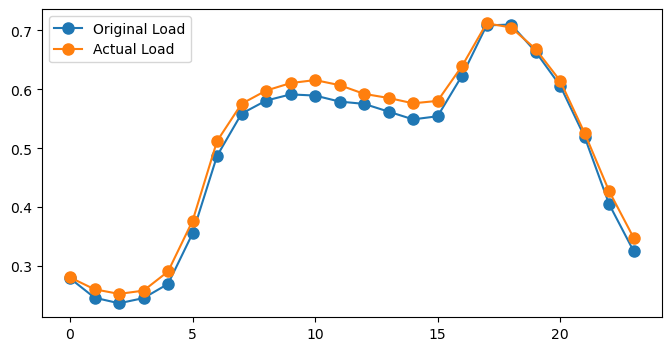

Inquiry 23: No valid strategy found, using original curve as fine-tuned result.
2873.260477551957
2844.5692746752648
2842.524108675929


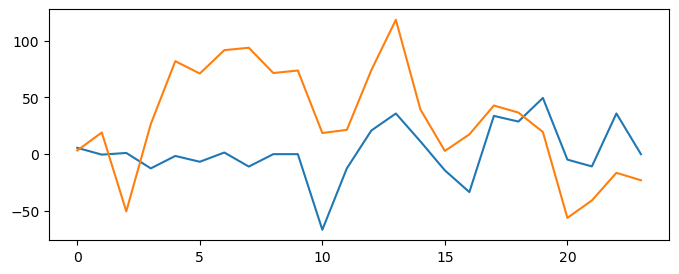

Processing inquiry 25/29
similar days original cost: 2576.9036490192316 similar days optnet cost: 2574.7032548169395
Found 3 similar days for inquiry 24
Generating few-shot prompts based on similar days...
策略生成尝试 #1 (当前有效策略: 0/20)
发现有效策略 strategy_2，成本 2565.92, 原始成本 2576.90, (降低 10.98)
发现有效策略 strategy_4，成本 2574.11, 原始成本 2576.90, (降低 2.79)
发现有效策略 strategy_8，成本 2575.48, 原始成本 2576.90, (降低 1.42)
发现有效策略 strategy_10，成本 2563.20, 原始成本 2576.90, (降低 13.71)
策略生成尝试 #2 (当前有效策略: 4/20)
发现有效策略 strategy_3，成本 2565.92, 原始成本 2576.90, (降低 10.98)
发现有效策略 strategy_6，成本 2575.43, 原始成本 2576.90, (降低 1.48)
发现有效策略 strategy_7，成本 2575.58, 原始成本 2576.90, (降低 1.32)
发现有效策略 strategy_10，成本 2574.25, 原始成本 2576.90, (降低 2.65)
策略生成尝试 #3 (当前有效策略: 8/20)
give actual value
发现有效策略 strategy_3，成本 2565.92, 原始成本 2576.90, (降低 10.98)
发现有效策略 strategy_4，成本 2574.11, 原始成本 2576.90, (降低 2.79)
发现有效策略 strategy_5，成本 2571.34, 原始成本 2576.90, (降低 5.56)
发现有效策略 strategy_6，成本 2575.43, 原始成本 2576.90, (降低 1.48)
发现有效策略 strategy_10，成本 2574.32, 原始成本 2576.90, (降

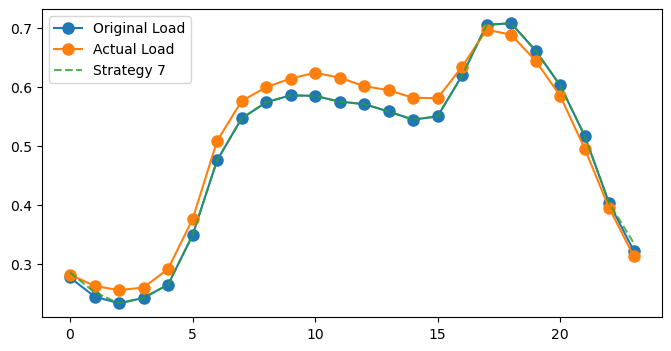

Found 1 relevant failed reflection cases for inquiry 24


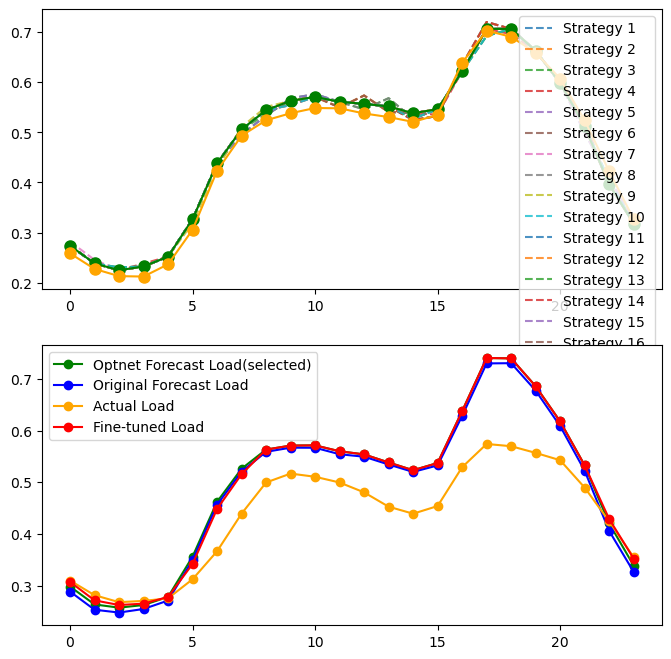

Original cost: 2824.4054184647202, Optnet cost: 2805.7448120818135, Fine-tuned cost: 2766.7397022784476
2871.3062751884677
2843.016296171527
2839.4927324200294


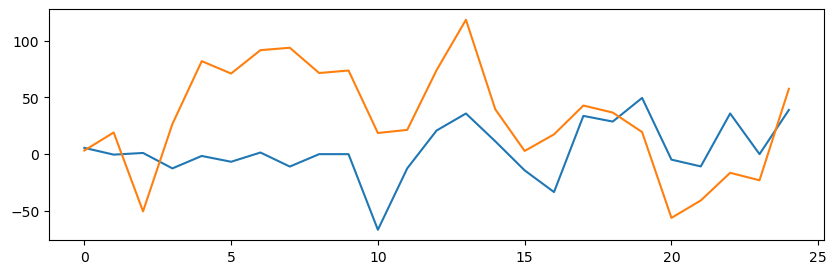

以下样本（inqure_id）未完成LLM微调，使用了原始预测曲线结果: [8, 9, 23]
以下样本（inqure_id）在验证集上未能找到有效策略，使用了原始预测曲线结果: []
Processing inquiry 26/29
similar days original cost: 2620.9823405791612 similar days optnet cost: 2583.962242279977
Found 3 similar days for inquiry 25
Generating few-shot prompts based on similar days...
策略生成尝试 #1 (当前有效策略: 0/20)
发现有效策略 strategy_1，成本 2604.42, 原始成本 2620.98, (降低 16.56)
发现有效策略 strategy_2，成本 2607.31, 原始成本 2620.98, (降低 13.68)
发现有效策略 strategy_5，成本 2607.69, 原始成本 2620.98, (降低 13.29)
发现有效策略 strategy_7，成本 2619.73, 原始成本 2620.98, (降低 1.25)
发现有效策略 strategy_8，成本 2616.66, 原始成本 2620.98, (降低 4.33)
发现有效策略 strategy_9，成本 2609.49, 原始成本 2620.98, (降低 11.49)
策略生成尝试 #2 (当前有效策略: 6/20)
发现有效策略 strategy_4，成本 2607.86, 原始成本 2620.98, (降低 13.12)
发现有效策略 strategy_7，成本 2616.34, 原始成本 2620.98, (降低 4.64)
发现有效策略 strategy_10，成本 2616.06, 原始成本 2620.98, (降低 4.92)
策略生成尝试 #3 (当前有效策略: 9/20)
give actual value
发现有效策略 strategy_1，成本 2607.45, 原始成本 2620.98, (降低 13.53)
发现有效策略 strategy_2，成本 2606.73, 原始成本 2620.98, (降低 14.26)
发现有效策略 

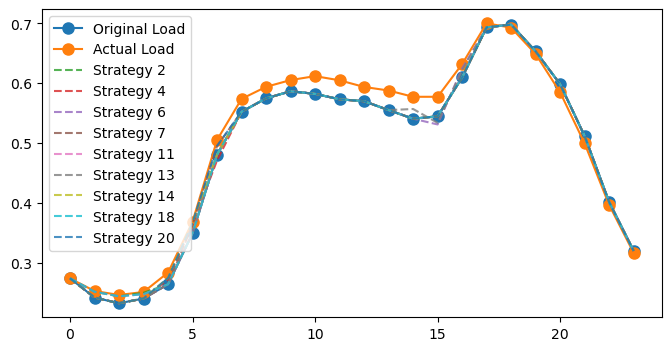

Found 1 relevant failed reflection cases for inquiry 25


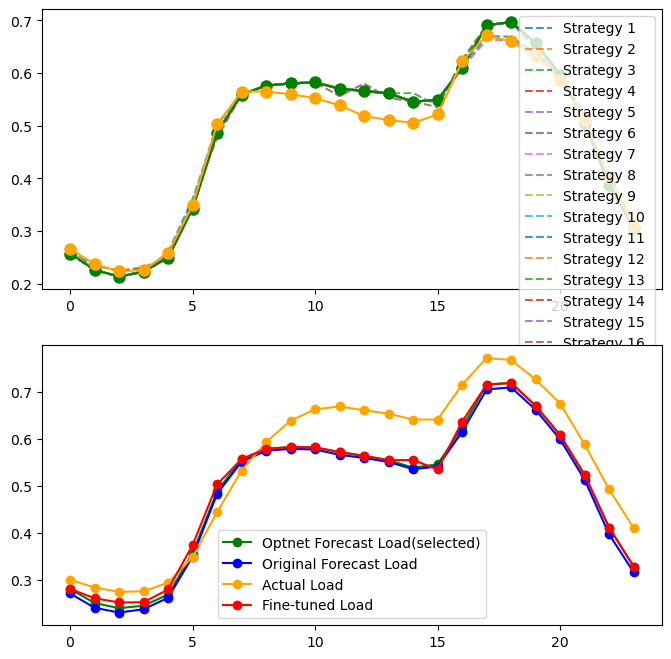

Original cost: 3708.977971447289, Optnet cost: 3599.360270661175, Fine-tuned cost: 3566.6116299957125
2903.5244173522683
2872.106449036513
2867.4588438652477


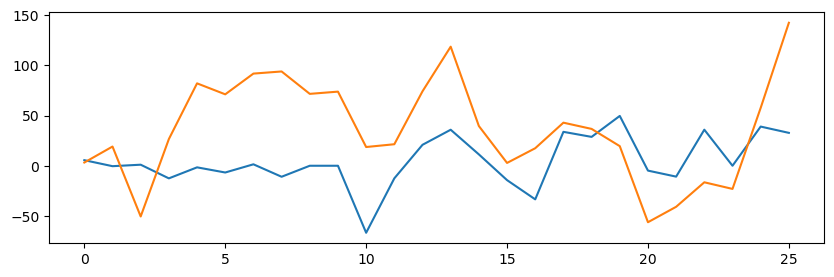

以下样本（inqure_id）未完成LLM微调，使用了原始预测曲线结果: [8, 9, 23]
以下样本（inqure_id）在验证集上未能找到有效策略，使用了原始预测曲线结果: []
Processing inquiry 27/29
similar days original cost: 2815.76591800187 similar days optnet cost: 2823.640954253117
Found 3 similar days for inquiry 26
Generating few-shot prompts based on similar days...
策略生成尝试 #1 (当前有效策略: 0/20)
发现有效策略 strategy_1，成本 2801.39, 原始成本 2815.77, (降低 14.37)
发现有效策略 strategy_3，成本 2794.48, 原始成本 2815.77, (降低 21.28)
发现有效策略 strategy_4，成本 2813.61, 原始成本 2815.77, (降低 2.15)
发现有效策略 strategy_5，成本 2810.10, 原始成本 2815.77, (降低 5.67)
发现有效策略 strategy_6，成本 2814.46, 原始成本 2815.77, (降低 1.31)
发现有效策略 strategy_7，成本 2807.45, 原始成本 2815.77, (降低 8.32)
发现有效策略 strategy_8，成本 2809.50, 原始成本 2815.77, (降低 6.26)
发现有效策略 strategy_9，成本 2814.11, 原始成本 2815.77, (降低 1.65)
发现有效策略 strategy_10，成本 2809.25, 原始成本 2815.77, (降低 6.52)
策略生成尝试 #2 (当前有效策略: 9/20)
发现有效策略 strategy_1，成本 2797.20, 原始成本 2815.77, (降低 18.57)
发现有效策略 strategy_2，成本 2792.55, 原始成本 2815.77, (降低 23.21)
发现有效策略 strategy_3，成本 2814.09, 原始成本 2815.77, (降低 1.68)
发

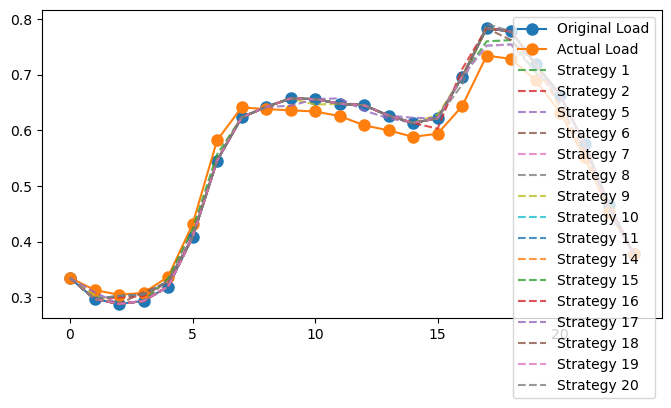

Found 1 relevant failed reflection cases for inquiry 26


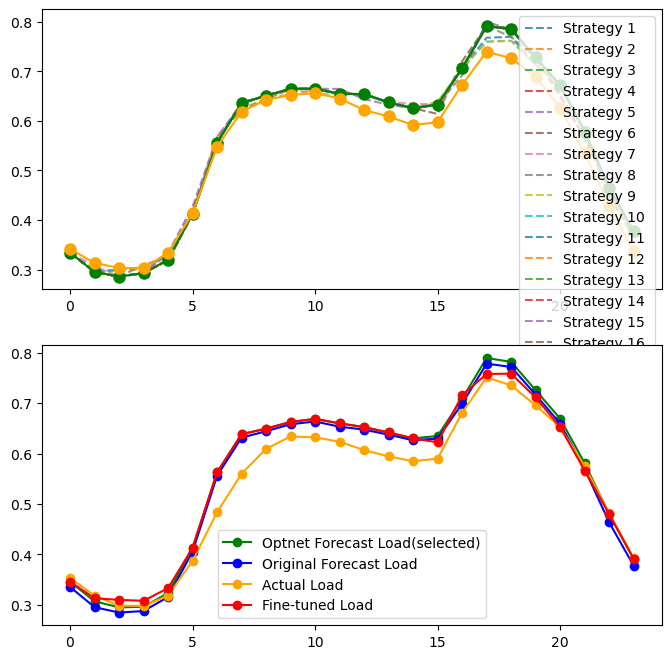

Original cost: 2837.3461347178218, Optnet cost: 2814.011486024797, Fine-tuned cost: 2794.078471547041
2901.0733698472886
2869.954783739783
2864.7410522979067


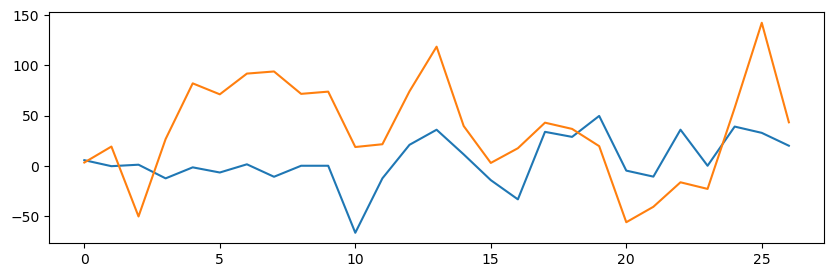

以下样本（inqure_id）未完成LLM微调，使用了原始预测曲线结果: [8, 9, 23]
以下样本（inqure_id）在验证集上未能找到有效策略，使用了原始预测曲线结果: []
Processing inquiry 28/29
similar days original cost: 2558.225305098057 similar days optnet cost: 2604.3764364105064
Found 3 similar days for inquiry 27
Generating few-shot prompts based on similar days...
策略生成尝试 #1 (当前有效策略: 0/20)
发现有效策略 strategy_1，成本 2539.89, 原始成本 2558.23, (降低 18.34)
发现有效策略 strategy_4，成本 2551.11, 原始成本 2558.23, (降低 7.11)
策略生成尝试 #2 (当前有效策略: 2/20)
发现有效策略 strategy_1，成本 2546.30, 原始成本 2558.23, (降低 11.93)
发现有效策略 strategy_8，成本 2549.06, 原始成本 2558.23, (降低 9.16)
策略生成尝试 #3 (当前有效策略: 4/20)
give actual value
发现有效策略 strategy_1，成本 2537.14, 原始成本 2558.23, (降低 21.08)
发现有效策略 strategy_4，成本 2551.67, 原始成本 2558.23, (降低 6.56)
发现有效策略 strategy_5，成本 2546.17, 原始成本 2558.23, (降低 12.05)
发现有效策略 strategy_8，成本 2549.99, 原始成本 2558.23, (降低 8.24)
策略生成尝试 #4 (当前有效策略: 8/20)
give actual value
发现有效策略 strategy_1，成本 2537.14, 原始成本 2558.23, (降低 21.08)
发现有效策略 strategy_2，成本 2551.67, 原始成本 2558.23, (降低 6.56)
发现有效策略 strategy_3，成本 

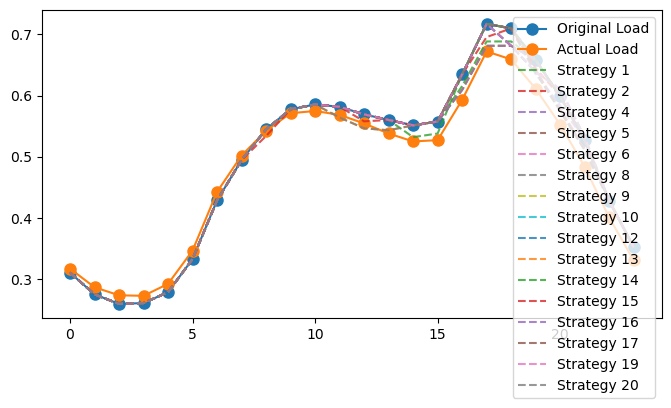

Found 1 relevant failed reflection cases for inquiry 27


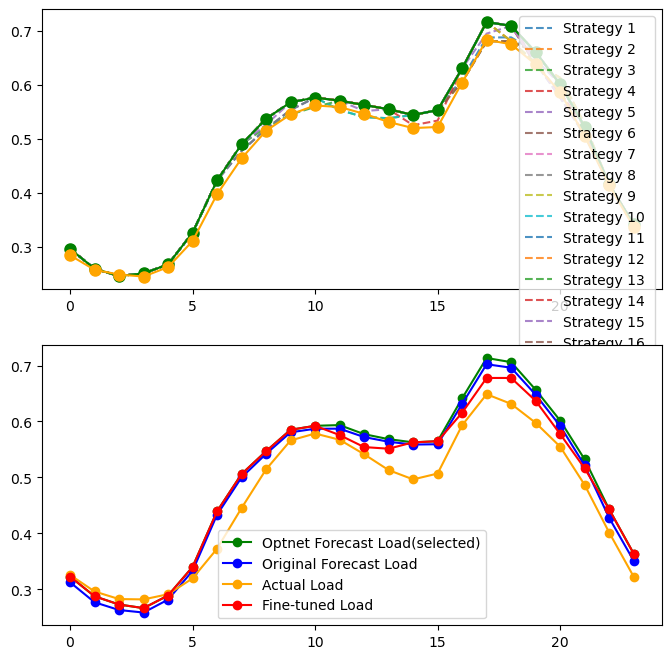

Original cost: 2690.5107073206304, Optnet cost: 2696.7482804403307, Fine-tuned cost: 2641.6028499773984
2893.553274757051
2863.7688371933737
2856.7718307864598


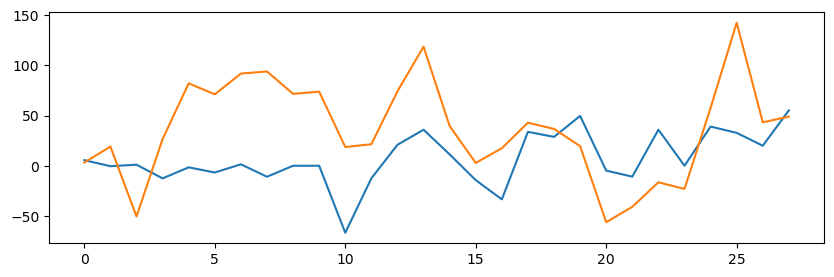

以下样本（inqure_id）未完成LLM微调，使用了原始预测曲线结果: [8, 9, 23]
以下样本（inqure_id）在验证集上未能找到有效策略，使用了原始预测曲线结果: []
Processing inquiry 29/29
similar days original cost: 2572.690603984793 similar days optnet cost: 2544.688111611983
Found 3 similar days for inquiry 28
Generating few-shot prompts based on similar days...
策略生成尝试 #1 (当前有效策略: 0/20)
发现有效策略 strategy_1，成本 2556.26, 原始成本 2572.69, (降低 16.43)
发现有效策略 strategy_3，成本 2570.27, 原始成本 2572.69, (降低 2.42)
发现有效策略 strategy_9，成本 2557.29, 原始成本 2572.69, (降低 15.40)
策略生成尝试 #2 (当前有效策略: 3/20)
发现有效策略 strategy_3，成本 2565.74, 原始成本 2572.69, (降低 6.95)
发现有效策略 strategy_5，成本 2548.26, 原始成本 2572.69, (降低 24.43)
发现有效策略 strategy_9，成本 2566.78, 原始成本 2572.69, (降低 5.91)
发现有效策略 strategy_10，成本 2556.79, 原始成本 2572.69, (降低 15.90)
策略生成尝试 #3 (当前有效策略: 7/20)
give actual value
发现有效策略 strategy_1，成本 2552.39, 原始成本 2572.69, (降低 20.30)
发现有效策略 strategy_2，成本 2570.07, 原始成本 2572.69, (降低 2.62)
发现有效策略 strategy_3，成本 2567.01, 原始成本 2572.69, (降低 5.68)
发现有效策略 strategy_4，成本 2565.74, 原始成本 2572.69, (降低 6.95)
发现有效策略 str

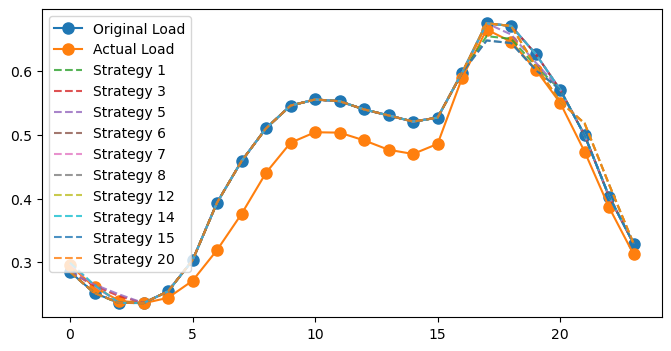

Found 1 relevant failed reflection cases for inquiry 28


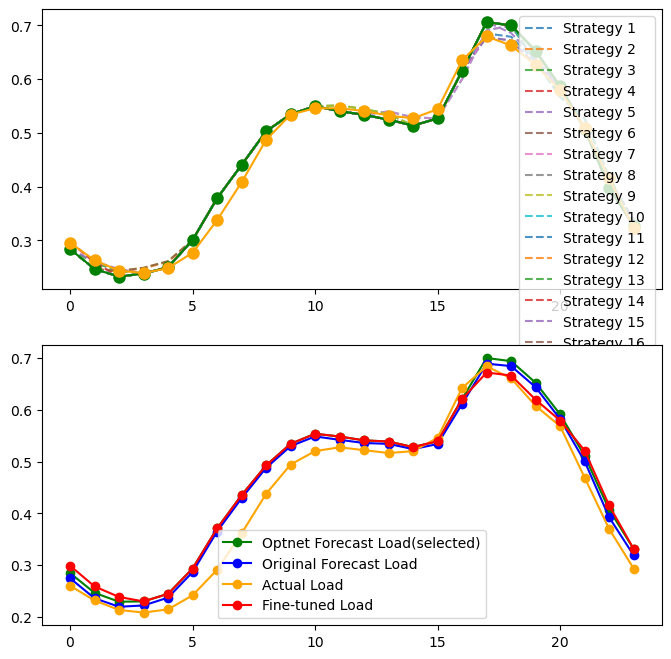

Original cost: 2545.1651810404655, Optnet cost: 2580.4118072267174, Fine-tuned cost: 2579.641618932313
2881.5398922151003
2853.997905125558
2847.215616584592


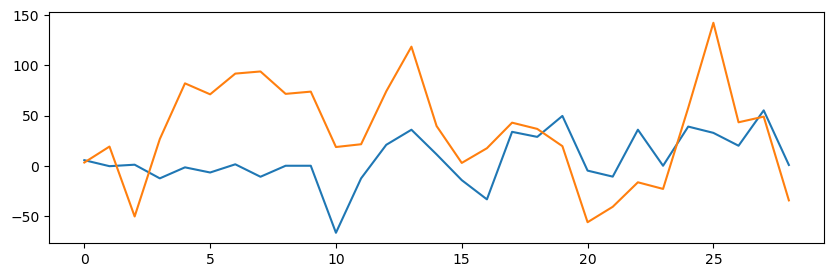

以下样本（inqure_id）未完成LLM微调，使用了原始预测曲线结果: [8, 9, 23]
以下样本（inqure_id）在验证集上未能找到有效策略，使用了原始预测曲线结果: []


In [ ]:
fine_tuned_result_given_by_LLM = {
    'selected_flag': [], 'original_load': [], 'optnet_load': [], 'fine_tuned_load': [], 
    'cost_org': [], 'cost_optnet': [], 'cost_after': [], 'actual_load': [],
    'few_shot_curves': [], 'few_shot_costs': [], 'few_shot_code': [], 
    'similar_load': [], 'similar_actual_load': [], 'strategy_code': []
}

skip_samples = []
validate_failures = []
reflection_records = []

for inqure_id in range(len(forecasts_load_test_insert)):
    print(f"Processing inquiry {inqure_id+1}/{len(forecasts_load_test_insert)}")
    data_for_inqure = {
        'load': forecasts_load_test_insert[inqure_id],
        'fine_tuned_load': forecasts_load_test_insert_optnet[inqure_id],
    }

    similar_days = db_train.get_top_k_unique_loads(data_for_inqure['load'], k=3, q=1)[0:3]
    average_similar_load_org = np.mean([day['load'] for day in similar_days], axis=0)
    average_similar_load_actual = np.mean([day['actual_load'] for day in similar_days], axis=0)
    average_similar_load_optnet = np.mean([day['fine_tuned_load'] for day in similar_days], axis=0)
    average_similar_load_org_numpy = train_load_data.scaler_y.inverse_transform(np.array(average_similar_load_org).reshape(1,-1))[0]
    average_similar_load_actual_numpy = train_load_data.scaler_y.inverse_transform(np.array(average_similar_load_actual).reshape(1,-1))[0]
    _, _, obj_org_similar_days = optimization_module.forward(average_similar_load_org_numpy, average_similar_load_actual_numpy)
    obj_org_similar_days = obj_org_similar_days.item()

    average_similar_load_optnet_numpy = train_load_data.scaler_y.inverse_transform(np.array(average_similar_load_optnet).reshape(1,-1))[0]
    _, _, obj_optnet_similar_days = optimization_module.forward(average_similar_load_optnet_numpy, average_similar_load_actual_numpy)
    obj_optnet_similar_days = obj_optnet_similar_days.item()

    print('Similar days original cost:', obj_org_similar_days, 'Similar days optnet cost:', obj_optnet_similar_days)
    selected_flag = 'optnet'
    load_nor = data_for_inqure['load']
    average_similar_load = average_similar_load_optnet
    actual_load_numpy = train_load_data.scaler_y.inverse_transform(np.array(actual_load_test_insert_optnet[inqure_id]).reshape(1,-1))[0]
    load_numpy_org = train_load_data.scaler_y.inverse_transform(np.array(data_for_inqure['load']).reshape(1,-1))[0]
    load_numpy_optnet = train_load_data.scaler_y.inverse_transform(np.array(data_for_inqure['fine_tuned_load']).reshape(1,-1))[0]

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    higher_flag = "higher" if sum(np.array(average_similar_load) - np.array(average_similar_load_actual)) > 0 else "lower"
    reduce_flag = "reduce" if higher_flag == "higher" else "increase"
    print(f"Found {len(similar_days)} similar days for inquiry {inqure_id}")
    
    system_prompt = generate_prompt_sys(args, data_for_inqure)

    full_user_prompt = f"SYSTEM INSTRUCTIONS:\n{system_prompt}."
    full_user_prompt += f"""\n\nHint: You have two approaches to reduce cost:  

    1. Compare the actual value and forecast of the similar day, try to learn some error reduction strategies. In historical similar days, we found the forecasts were {higher_flag} than actual, so you can try to {reduce_flag} the load in some hours to reduce cost.  
    2. Compare the future positive and negative reserve prices.  
    - If the positive reserve price is much higher than the negative reserve price, you should schedule more generation in the day-ahead market.  
    - If the negative reserve price is higher, schedule less generation to reduce potential costs.  
    """

    # Few-shot code integration
    print("Generating few-shot prompts based on similar days...")
    strategy_history, valid_strategies = few_shot_prompt_generate(args, similar_days, max_strategies=20, max_attempts=6)
    
    # Validate strategies on validation set
    selected_strategy = []
    similar_days_val = db_val.get_top_k_unique_loads(data_for_inqure['load'], k=3, q=1)[0:3]
    average_similar_load_val = np.mean([day['load'] for day in similar_days_val], axis=0)
    average_similar_load_actual_val = np.mean([day['actual_load'] for day in similar_days_val], axis=0)
    plt.figure(figsize=(8, 4))
    plt.plot(range(len(average_similar_load_val)), average_similar_load_val, markersize=8, marker='o', label='Original Load')
    plt.plot(range(len(average_similar_load_val)), average_similar_load_actual_val, markersize=8, marker='o', label='Actual Load')
    
    load_nor_val = average_similar_load_val.tolist()
    load_val_numpy = train_load_data.scaler_y.inverse_transform(np.array(load_nor_val).reshape(1,-1))[0]
    actual_load_val_numpy = train_load_data.scaler_y.inverse_transform(np.array(average_similar_load_actual_val).reshape(1,-1))[0]

    for strategy in valid_strategies:
        strategy_result = evaluate_individual_strategies(
            strategy['code'],
            load_nor_val,
            max_change_percent=0.1
        )
        try:
            selected_curve_val = strategy_result[list(strategy_result.keys())[0]]['adjusted_curve']
        except Exception as e:
            print(f"Error evaluating strategy {strategy['name']}: {e}")
            continue
        
        fine_tuned_load_val_numpy = train_load_data.scaler_y.inverse_transform(np.array(selected_curve_val).reshape(1,-1))[0]
        _, _, obj_org_val = optimization_module.forward(load_val_numpy, actual_load_val_numpy)
        _, _, obj_fine_tune_val = optimization_module.forward(fine_tuned_load_val_numpy, actual_load_val_numpy)

        if obj_org_val > obj_fine_tune_val:
            selected_strategy.append(strategy)
            plt.plot(range(24), selected_curve_val, label=strategy['name'], linestyle='--', alpha=0.8)
            print(f"Strategy {strategy['name']} succeeded on validation set, cost {obj_fine_tune_val.item():.2f}, original cost {obj_org_val.item():.2f}, (reduction {obj_org_val.item()-obj_fine_tune_val.item():.2f})")
        else:
            print(f"Strategy {strategy['name']} failed on validation set, cost {obj_fine_tune_val.item():.2f}, original cost {obj_org_val.item():.2f}, (increase {obj_org_val.item()-obj_fine_tune_val.item():.2f})")
    plt.legend()
    plt.show()

    if len(selected_strategy) == 0:
        print(f"Inquiry {inqure_id}: No valid strategy found, using original curve as fine-tuned result.")

        _, _, obj_org = optimization_module.forward(load_numpy_org, actual_load_numpy)
        _, _, obj_optnet = optimization_module.forward(load_numpy_optnet, actual_load_numpy)

        if selected_flag == 'org':
            fine_tuned_result_given_by_LLM['fine_tuned_load'].append(data_for_inqure['load'])
            fine_tuned_result_given_by_LLM['cost_after'].append(obj_org.item())
        else:
            fine_tuned_result_given_by_LLM['fine_tuned_load'].append(data_for_inqure['fine_tuned_load'])
            fine_tuned_result_given_by_LLM['cost_after'].append(obj_optnet.item())

        fine_tuned_result_given_by_LLM['selected_flag'].append(selected_flag)
        fine_tuned_result_given_by_LLM['actual_load'].append(actual_load_test_insert[inqure_id])
        fine_tuned_result_given_by_LLM['original_load'].append(data_for_inqure['load'])
        fine_tuned_result_given_by_LLM['optnet_load'].append(data_for_inqure['fine_tuned_load'])
        fine_tuned_result_given_by_LLM['similar_load'].append(average_similar_load.tolist())
        fine_tuned_result_given_by_LLM['similar_actual_load'].append(average_similar_load_actual.tolist())
        fine_tuned_result_given_by_LLM['cost_org'].append(obj_org.item())
        fine_tuned_result_given_by_LLM['cost_optnet'].append(obj_optnet.item())
        fine_tuned_result_given_by_LLM['few_shot_costs'].append([])
        fine_tuned_result_given_by_LLM['few_shot_curves'].append([])
        fine_tuned_result_given_by_LLM['few_shot_code'].append([])
        fine_tuned_result_given_by_LLM['strategy_code'].append('')
        skip_samples.append(inqure_id)
    
        if len(fine_tuned_result_given_by_LLM['cost_org']) > 1:
            print(np.mean(fine_tuned_result_given_by_LLM['cost_org']))
            print(np.mean(fine_tuned_result_given_by_LLM['cost_optnet']))
            print(np.mean(fine_tuned_result_given_by_LLM['cost_after']))
            plt.figure(figsize=(8, 3))
            plt.plot(
                range(len(fine_tuned_result_given_by_LLM['cost_org'])),
                np.array(fine_tuned_result_given_by_LLM['cost_optnet']) - np.array(fine_tuned_result_given_by_LLM['cost_after']),
                label='Compared to optnet'
            )
            plt.plot(
                range(len(fine_tuned_result_given_by_LLM['cost_org'])),
                np.array(fine_tuned_result_given_by_LLM['cost_org']) - np.array(fine_tuned_result_given_by_LLM['cost_after']),
                label='Compared to original'
            )
            plt.show()
            plt.close()
        continue

    # Build few-shot LLM prompt
    few_shot_costs = [s['final_cost'] for s in selected_strategy]
    few_shot_curves = [s['adjusted_curve'] for s in selected_strategy]
    few_shot_codes = [s['code'] for s in selected_strategy]
    history_snippet_prompt = 'Here are some previously discovered effective adjustment strategies:\n'
    for i, s in enumerate(selected_strategy):
        history_snippet_prompt += f"Good strategy {i+1} from few-shot:\n{s['code']}\n\n"
    history_snippet_prompt += f"You should ensemble these strategies as you can only output one adjustment_strategy function.\n"

    last_fail_reflections = get_fail_reflections_by_curve_distance(reflection_records, data_for_inqure['load'], max_num=1)
    print(f"Found {len(last_fail_reflections)} relevant failed reflection cases for inquiry {inqure_id}")
    fail_reflections_prompt = ""
    if last_fail_reflections:
        fail_reflections_prompt = 'You have failed in these examples and led to cost increase, avoid these patterns:\n'
        fail_reflections_prompt += "\n### Previous failed adjustment text examples (avoid these patterns):\n"
        for idx, record in enumerate(last_fail_reflections):
            fail_reflections_prompt += (
                f"Fail Case {idx + 1}:\n"
                f"- Last failed strategy:\n{remove_comments(record['strategy_code'])}\n\n"
                f"- Please try to consider these successful strategies:\n"
                f"- Successful strategy:\n{(record['reflection_strategy'])}\n\n"
            )

    if args.LLM_type == 'Qwen':
        response = Generation.call(
            model="qwen-plus",
            messages=[
                {"role": "system", "content": full_user_prompt},
                {"role": "user", "content": output_require_prompt},
                {"role": "assistant", "content": history_snippet_prompt},
                {"role": "assistant", "content": fail_reflections_prompt},
            ],
            parameters={
                "temperature": 0.1,
                "result_format": "text",
                "max_tokens": 2048,
                "top_k": 10
            }
        )
        
        raw_text = response.choices[0].message.content.strip()
        func_code = extract_pure_code(raw_text)
    
    elif args.LLM_type == 'Deepseek':
        client = OpenAI(api_key=DEEPSEEK_API_KEY,
                base_url="https://api.deepseek.com")
        
        response = client.chat.completions.create(
        model="deepseek-chat",
        messages=[
            {"role": "system", "content": full_user_prompt},
            {"role": "user", "content": output_require_prompt},
            {"role": "assistant", "content": history_snippet_prompt},
            {"role": "assistant", "content": fail_reflections_prompt},
        ],
        temperature=0.1,
        max_tokens=2048,
        stream=False,
        )
    
        raw_text = response.choices[0].message.content.strip()
        func_code = extract_pure_code(raw_text)

    elif args.LLM_type == 'Llama':
        client = Together(api_key=LLAMA_API_KEY)
        response = client.chat.completions.create(
            model="meta-llama/Llama-4-Maverick-17B-128E-Instruct-FP8",
            messages=[
            {"role": "system", "content": full_user_prompt},
            {"role": "user", "content": output_require_prompt},
            {"role": "assistant", "content": history_snippet_prompt},
            {"role": "assistant", "content": fail_reflections_prompt},
        ],
        temperature=0.1,
        max_tokens=2048,
        )
        raw_text = response.choices[0].message.content.strip()
        func_code = extract_pure_code(raw_text)
        
    if selected_flag == 'org':
        selected_curve, delta_curve, strategy_code = execute_strategy_function(
            func_code,
            data_for_inqure['load'],
            max_change_percent=0.15
        )
    else:
        selected_curve, delta_curve, strategy_code = execute_strategy_function(
            func_code,
            data_for_inqure['fine_tuned_load'],
            max_change_percent=0.15
        )

    fine_tuned_load_numpy =  train_load_data.scaler_y.inverse_transform(np.array(selected_curve).reshape(1, -1))[0]
    _, _, obj_org = optimization_module.forward(load_numpy_org, actual_load_numpy)
    _, _, obj_optnet = optimization_module.forward(load_numpy_optnet, actual_load_numpy)
    _, _, obj_fine_tune = optimization_module.forward(fine_tuned_load_numpy, actual_load_numpy)

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    for i in valid_strategies:
        plt.plot(i['adjusted_curve'], label=i['name'], linestyle='--', alpha=0.8)
    if selected_flag == 'org':
        plt.plot(range(24), i['original_load'], markersize=8, marker='o', label='Original Load', color='blue')
    else:
        plt.plot(range(24), i['original_load'], markersize=8, marker='o', label='Optnet Load', color='green')
    plt.plot(range(24), i['actual_load'], markersize=8, marker='o', label='Actual Load', color='orange')
    plt.legend()

    plt.subplot(2, 1, 2)
    if selected_flag == 'org':
        plt.plot(range(24), data_for_inqure['load'], label='Original Forecast Load(selected)', marker='o', color='blue')
        plt.plot(range(24), data_for_inqure['fine_tuned_load'], label='Optnet Forecast Load', marker='o', color='green')
    else:
        plt.plot(range(24), data_for_inqure['fine_tuned_load'], label='Optnet Forecast Load(selected)', marker='o', color='green')
        plt.plot(range(24), data_for_inqure['load'], label='Original Forecast Load', marker='o', color='blue')
    plt.plot(range(24), actual_load_test_insert[inqure_id], label='Actual Load', marker='o', color='orange')
    plt.plot(range(24), selected_curve, label='Fine-tuned Load', marker='o', color='red')
    plt.legend()
    plt.show()
    print(f"Original cost: {obj_org.item()}, Optnet cost: {obj_optnet.item()}, Fine-tuned cost: {obj_fine_tune.item()}")

    if selected_flag == 'org' and obj_fine_tune.item() < obj_org.item():
            reflection_strategy = "Cost reduction achieved."
            insight = f"Successfully reduced cost by {obj_org.item() - obj_fine_tune.item():.2f}."
    elif selected_flag == 'org' and obj_fine_tune.item() > obj_org.item():
        failures = [{
            "inqure_id": inqure_id,
            "load": data_for_inqure['load'],
            "actual_load": actual_load_test_insert[inqure_id],
            'fine_tuned_load': selected_curve,
            "cost_before": obj_org.item(),
            "cost_after": obj_fine_tune.item(),
            "strategy_code": strategy_code,
        }]

        reflection_strategy_history, reflection_valid_strategies = few_shot_prompt_generate(args, failures, max_strategies=5, max_attempts=3)
        reflection_strategy = f"For this failure case, consider:"
        for i in range(len(reflection_valid_strategies)):
            strategy = reflection_valid_strategies[i]
            reflection_strategy += f"Successful strategy {i} for failure case:\n{remove_comments(strategy['code'])}\n"

    if selected_flag == 'optnet' and obj_fine_tune.item() < obj_optnet.item():
            reflection_strategy = "Cost reduction achieved."
            insight = f"Successfully reduced cost by {obj_optnet.item() - obj_fine_tune.item():.2f}."
    elif selected_flag == 'optnet' and obj_fine_tune.item() > obj_optnet.item():
        failures = [{
            "inqure_id": inqure_id,
            "load": data_for_inqure['load'],
            "actual_load": actual_load_test_insert[inqure_id],
            'fine_tuned_load': selected_curve,
            "cost_before": obj_optnet.item(),
            "cost_after": obj_fine_tune.item(),
            "strategy_code": strategy_code,
        }]

        reflection_strategy_history, reflection_valid_strategies = few_shot_prompt_generate(args, failures, max_strategies=5, max_attempts=3)
        reflection_strategy = f"For this failure case, consider:"
        for i in range(len(reflection_valid_strategies)):
            strategy = reflection_valid_strategies[i]
            reflection_strategy += f"Successful strategy {i} for failure case:\n{remove_comments(strategy['code'])}\n"

    reflection_records.append({
        "inquiry_id": inqure_id,
        "original_load": data_for_inqure['load'],
        "actual_load": actual_load_test_insert[inqure_id],
        "fine_tuned_load": selected_curve,
        "cost_before": obj_org.item(),
        "cost_after": obj_fine_tune.item(),
        "strategy_code": strategy_code,
        "reflection_strategy": reflection_strategy,
        "similar_day_comparison": f"Similar days showed forecast was {higher_flag} than actual"
    })
    reflection_records = reflection_records[-10:]  # Keep only last 10 records

    fine_tuned_result_given_by_LLM['selected_flag'].append(selected_flag)
    fine_tuned_result_given_by_LLM['actual_load'].append(actual_load_test_insert[inqure_id])
    fine_tuned_result_given_by_LLM['original_load'].append(data_for_inqure['load'])
    fine_tuned_result_given_by_LLM['optnet_load'].append(data_for_inqure['fine_tuned_load'])
    fine_tuned_result_given_by_LLM['fine_tuned_load'].append(selected_curve)
    fine_tuned_result_given_by_LLM['cost_after'].append(obj_fine_tune.item())
    fine_tuned_result_given_by_LLM['cost_org'].append(obj_org.item())
    fine_tuned_result_given_by_LLM['cost_optnet'].append(obj_optnet.item())
    fine_tuned_result_given_by_LLM['similar_load'].append(average_similar_load.tolist())
    fine_tuned_result_given_by_LLM['similar_actual_load'].append(average_similar_load_actual.tolist())
    fine_tuned_result_given_by_LLM['few_shot_costs'].append(few_shot_costs)
    fine_tuned_result_given_by_LLM['few_shot_curves'].append(few_shot_curves)
    fine_tuned_result_given_by_LLM['few_shot_code'].append(few_shot_codes)
    fine_tuned_result_given_by_LLM['strategy_code'].append(strategy_code)

    if len(fine_tuned_result_given_by_LLM['cost_org']) > 1:
        print(np.mean(fine_tuned_result_given_by_LLM['cost_org']))
        print(np.mean(fine_tuned_result_given_by_LLM['cost_optnet']))
        print(np.mean(fine_tuned_result_given_by_LLM['cost_after']))
        plt.figure(figsize=(10, 3))
        plt.plot(
            range(len(fine_tuned_result_given_by_LLM['cost_org'])),
            np.array(fine_tuned_result_given_by_LLM['cost_optnet']) - np.array(fine_tuned_result_given_by_LLM['cost_after']),
            label='Compared to optnet'
        )
        plt.plot(
            range(len(fine_tuned_result_given_by_LLM['cost_org'])),
            np.array(fine_tuned_result_given_by_LLM['cost_org']) - np.array(fine_tuned_result_given_by_LLM['cost_after']),
            label='Compared to original'
        )

        plt.show()
        plt.close()

    print(f"The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: {skip_samples}")
    print(f"The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: {validate_failures}")

    with open('NN+LP_'+args.LLM_type+'.pkl', 'wb') as f:
        pickle.dump(fine_tuned_result_given_by_LLM, f)

### result

In [21]:
print(np.mean(fine_tuned_result_given_by_LLM['cost_org']))
print(np.mean(fine_tuned_result_given_by_LLM['cost_optnet']))
print(np.mean(fine_tuned_result_given_by_LLM['cost_after']))
print(np.mean(cost_list_ideal))

2881.5398922151003
2853.997905125558
2847.215616584592
2523.7132705132676
